In [1]:
import json
import torch as t
import os
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from behaviors import HUMAN_NAMES, get_activations_path, get_ab_data_path, get_analysis_dir
from utils.helpers import get_model_path

import torch.nn.functional as F

DATASET_FILE = os.path.join("preprocessed_data", "generate_dataset.json")

def get_train_dev_split(pos_acts, neg_acts, ratio=0.8):
    n = pos_acts.shape[0]
    n_train = int(n * ratio)

    print(f"train count: {n_train}")
    print(f"test count: {n - n_train}")
    print()
    return (
        pos_acts[:n_train], neg_acts[:n_train],
        pos_acts[n_train:], neg_acts[n_train:]
    )

def baseline(pos_train, neg_train, pos_dev, neg_dev):
    mse = F.mse_loss(pos_dev, neg_dev).item()
    return mse, 0.0

def mean_diff_method(pos_train, neg_train, pos_dev, neg_dev):
    diff_vec = pos_train.mean(dim=0) - neg_train.mean(dim=0)
    prediction = neg_dev + diff_vec
    mse = F.mse_loss(pos_dev, prediction).item()
    sim = F.cosine_similarity(prediction - neg_dev, pos_dev - neg_dev, dim=1).mean().item()
    return mse, sim

def pca_diff_method(pos_train, neg_train, pos_dev, neg_dev, coeff_range=[-2, -1, 0, 1, 2]):
    diffs = pos_train - neg_train
    diffs_np = diffs.cpu().numpy()
    pca = PCA(n_components=1)
    pca.fit(diffs_np)
    pc1 = t.tensor(pca.components_[0], device=pos_dev.device, dtype=pos_dev.dtype)

    results = {}
    for coeff in coeff_range:
        prediction = neg_dev + coeff * pc1
        mse = F.mse_loss(pos_dev, prediction).item()
        sim = F.cosine_similarity(prediction - neg_dev, pos_dev - neg_dev, dim=1).mean().item()
        results[coeff] = {"mse": mse, "sim": sim}
    return results

def retrieval_diff_method(pos_train, neg_train, pos_dev, neg_dev, top_k=1):
    diff_train = pos_train - neg_train
    neg_train_norm = F.normalize(neg_train, dim=1)
    neg_dev_norm = F.normalize(neg_dev, dim=1)
    sim_matrix = neg_dev_norm @ neg_train_norm.T
    topk_scores, topk_indices = sim_matrix.topk(top_k, dim=1)
    retrieved_diffs = diff_train[topk_indices]
    retrieved_diff_mean = retrieved_diffs.mean(dim=1)
    pred_pos_dev = neg_dev + retrieved_diff_mean
    mse = F.mse_loss(pred_pos_dev, pos_dev).item()
    sim = F.cosine_similarity(pred_pos_dev - neg_dev, pos_dev - neg_dev, dim=1).mean().item()
    return mse, sim

def retrieval_custom_method(query, key, diff_values, gold, neg_dev, top_k=1):
    key_norm = F.normalize(key, dim=1)
    query_norm = F.normalize(query, dim=1)
    sim_matrix = query_norm @ key_norm.T
    topk_scores, topk_indices = sim_matrix.topk(top_k, dim=1)
    retrieved_diffs = diff_values[topk_indices]
    retrieved_diff_mean = retrieved_diffs.mean(dim=1)
    prediction = query + retrieved_diff_mean
    mse = F.mse_loss(prediction, gold).item()
    sim = F.cosine_similarity(prediction - neg_dev, gold - neg_dev, dim=1).mean().item()
    return mse, sim

def analyze(behavior: str, layer: int, model_name_path: str, activation_type: str = None):
    save_dir = os.path.join(get_analysis_dir(behavior), f"analysis-{activation_type}" if activation_type else "analysis")
    os.makedirs(save_dir, exist_ok=True)

    pos_acts = t.load(get_activations_path(behavior, layer, model_name_path, "pos", type=activation_type))
    neg_acts = t.load(get_activations_path(behavior, layer, model_name_path, "neg", type=activation_type))

    pos_train, neg_train, pos_dev, neg_dev = get_train_dev_split(pos_acts, neg_acts)

    print(f"Analyzing {behavior}, layer {layer}")

    result_dict = {}

    baseline_mse, _ = baseline(pos_train, neg_train, pos_dev, neg_dev)
    print(f"[Baseline] Dev MSE: {baseline_mse:.4f}")
    result_dict["baseline"] = {
        "mse": baseline_mse,
        "sim": 0.0,
        "relative_to_baseline": 1.0
    }

    mean_diff_mse, mean_diff_sim = mean_diff_method(pos_train, neg_train, pos_dev, neg_dev)
    print(f"[Mean Difference] Dev MSE: {mean_diff_mse:.4f}, CosSim: {mean_diff_sim:.4f}")
    result_dict["mean_diff"] = {
        "mse": mean_diff_mse,
        "sim": mean_diff_sim,
        "relative_to_baseline": mean_diff_mse / baseline_mse
    }

    pca_mse_results = pca_diff_method(pos_train, neg_train, pos_dev, neg_dev)
    for coeff, result in pca_mse_results.items():
        print(f"[PCA coeff {coeff:+}] Dev MSE: {result['mse']:.4f}, CosSim: {result['sim']:.4f}")
    result_dict["pca_diff"] = {
        f"coeff_{coeff:+}": {
            "mse": result["mse"],
            "sim": result["sim"],
            "relative_to_baseline": result["mse"] / baseline_mse
        } for coeff, result in pca_mse_results.items()
    }

    result_dict["retrieval_diff"] = {}
    for k in [1, 3, 5, 10, 20]:
        mse, sim = retrieval_diff_method(pos_train, neg_train, pos_dev, neg_dev, top_k=k)
        print(f"[Retrieval diff transfer k={k}] Dev MSE = {mse:.4f}, CosSim = {sim:.4f}")
        result_dict["retrieval_diff"][f"top_k_{k}"] = {
            "mse": mse,
            "sim": sim,
            "relative_to_baseline": mse / baseline_mse
        }

    setups = {
        "neg-retrieval": (neg_dev, neg_train, pos_train - neg_train, pos_dev),
        "pos-retrieval": (pos_dev, pos_train, pos_train - neg_train, pos_dev),
    }
    result_dict["retrieval_custom"] = {}
    for setup_name, (q, k, v, gold) in setups.items():
        for top_k in [1, 3, 5, 10]:
            mse, sim = retrieval_custom_method(q, k, v, gold, neg_dev, top_k=top_k)
            print(f"[{setup_name} k={top_k}] Dev MSE = {mse:.4f}, CosSim = {sim:.4f}")
            result_dict["retrieval_custom"].setdefault(setup_name, {})[f"top_k_{top_k}"] = {
                "mse": mse,
                "sim": sim,
                "relative_to_baseline": mse / baseline_mse
            }

    return result_dict


In [2]:
behavior = "refusal"
layers = range(32)

model_name_path = "Llama-2-7b-chat-hf"
activation_type = None

for layer in layers:
    analyze(behavior, layer, model_name_path, activation_type)

train count: 326
test count: 82

Analyzing refusal, layer 0
[Baseline] Dev MSE: 0.0005
[Mean Difference] Dev MSE: 0.0005, CosSim: 0.0488
[PCA coeff -2] Dev MSE: 0.0015, CosSim: -0.0489
[PCA coeff -1] Dev MSE: 0.0008, CosSim: -0.0489
[PCA coeff +0] Dev MSE: 0.0005, CosSim: 0.0000
[PCA coeff +1] Dev MSE: 0.0007, CosSim: 0.0489
[PCA coeff +2] Dev MSE: 0.0014, CosSim: 0.0489
[Retrieval diff transfer k=1] Dev MSE = 0.0000, CosSim = 0.9991
[Retrieval diff transfer k=3] Dev MSE = 0.0000, CosSim = 0.9993
[Retrieval diff transfer k=5] Dev MSE = 0.0000, CosSim = 0.9993
[Retrieval diff transfer k=10] Dev MSE = 0.0000, CosSim = 0.9993
[Retrieval diff transfer k=20] Dev MSE = 0.0000, CosSim = 0.9993
[neg-retrieval k=1] Dev MSE = 0.0000, CosSim = 0.9991
[neg-retrieval k=3] Dev MSE = 0.0000, CosSim = 0.9993
[neg-retrieval k=5] Dev MSE = 0.0000, CosSim = 0.9993
[neg-retrieval k=10] Dev MSE = 0.0000, CosSim = 0.9993
[pos-retrieval k=1] Dev MSE = 0.0005, CosSim = 0.9998
[pos-retrieval k=3] Dev MSE = 0.0

In [3]:
import os
import json
import torch as t
import matplotlib.pyplot as plt

def run_analyze_and_collect(behavior, layers, model_name_path, activation_type=None):
    results_by_layer = {}

    for layer in layers:
        print(f"Running analyze on layer {layer}")
        result_dict = analyze(behavior, layer, model_name_path, activation_type)
        results_by_layer[layer] = result_dict

    return results_by_layer

def plot_layerwise_metrics(behavior, results_by_layer, metric_type="relative_to_baseline"):
    layers = sorted(results_by_layer.keys())

    methods = [
        "baseline",
        "mean_diff",
        "pca_diff",
        "retrieval_custom/neg-retrieval",
        "retrieval_custom/pos-retrieval",
    ]

    colors = {
        "baseline": "red",
        "mean_diff": "blue",
        "pca_diff": "orange",
        "retrieval_custom/neg-retrieval": "green",
        "retrieval_custom/pos-retrieval": "purple",
    }

    plt.figure(figsize=(12, 7))
    for method in methods:
        values = []
        for layer in layers:
            parts = method.split("/")
            result = results_by_layer[layer]

            if len(parts) == 1:  # direct method like baseline or mean_diff
                result_entry = result.get(parts[0])
                if result_entry is None:
                    values.append(None)
                    continue
                if parts[0] == "pca_diff":
                    v = min(r[metric_type] for r in result_entry.values())
                else:
                    v = result_entry[metric_type]
            else:  # retrieval_custom/setupX
                result_group = result.get(parts[0], {}).get(parts[1], {})
                if not result_group:
                    values.append(None)
                    continue
                v = min(r[metric_type] for r in result_group.values())

            values.append(v)

        label_name = method.replace("retrieval_custom/", "setup_").replace("_", " ")
        plt.plot(layers, values, label=label_name, color=colors[method], marker='o')

    plt.title(f"[{behavior}] Layer-wise {metric_type.replace('_', ' ').title()}")
    plt.xlabel("Layer")
    plt.ylabel(metric_type.replace("_", " ").title())
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Running analyze on layer 0
train count: 288
test count: 72

Analyzing coordinate-other-ais, layer 0
[Baseline] Dev MSE: 0.0005
[Mean Difference] Dev MSE: 0.0005, CosSim: -0.0252
[PCA coeff -2] Dev MSE: 0.0015, CosSim: -0.0278
[PCA coeff -1] Dev MSE: 0.0008, CosSim: -0.0278
[PCA coeff +0] Dev MSE: 0.0005, CosSim: 0.0000
[PCA coeff +1] Dev MSE: 0.0007, CosSim: 0.0278
[PCA coeff +2] Dev MSE: 0.0014, CosSim: 0.0278
[Retrieval diff transfer k=1] Dev MSE = 0.0000, CosSim = 0.9996
[Retrieval diff transfer k=3] Dev MSE = 0.0000, CosSim = 0.9997
[Retrieval diff transfer k=5] Dev MSE = 0.0000, CosSim = 0.9997
[Retrieval diff transfer k=10] Dev MSE = 0.0000, CosSim = 0.9997
[Retrieval diff transfer k=20] Dev MSE = 0.0000, CosSim = 0.9997
[neg-retrieval k=1] Dev MSE = 0.0000, CosSim = 0.9996
[neg-retrieval k=3] Dev MSE = 0.0000, CosSim = 0.9997
[neg-retrieval k=5] Dev MSE = 0.0000, CosSim = 0.9997
[neg-retrieval k=10] Dev MSE = 0.0000, CosSim = 0.9997
[pos-retrieval k=1] Dev MSE = 0.0005, CosSim =

[PCA coeff -2] Dev MSE: 0.0019, CosSim: -0.0276
[PCA coeff -1] Dev MSE: 0.0012, CosSim: -0.0276
[PCA coeff +0] Dev MSE: 0.0009, CosSim: 0.0000
[PCA coeff +1] Dev MSE: 0.0011, CosSim: 0.0276
[PCA coeff +2] Dev MSE: 0.0018, CosSim: 0.0276
[Retrieval diff transfer k=1] Dev MSE = 0.0000, CosSim = 0.9974
[Retrieval diff transfer k=3] Dev MSE = 0.0000, CosSim = 0.9983
[Retrieval diff transfer k=5] Dev MSE = 0.0000, CosSim = 0.9984
[Retrieval diff transfer k=10] Dev MSE = 0.0000, CosSim = 0.9984
[Retrieval diff transfer k=20] Dev MSE = 0.0000, CosSim = 0.9983
[neg-retrieval k=1] Dev MSE = 0.0000, CosSim = 0.9974
[neg-retrieval k=3] Dev MSE = 0.0000, CosSim = 0.9983
[neg-retrieval k=5] Dev MSE = 0.0000, CosSim = 0.9984
[neg-retrieval k=10] Dev MSE = 0.0000, CosSim = 0.9984
[pos-retrieval k=1] Dev MSE = 0.0009, CosSim = 0.9994
[pos-retrieval k=3] Dev MSE = 0.0009, CosSim = 0.9996
[pos-retrieval k=5] Dev MSE = 0.0009, CosSim = 0.9996
[pos-retrieval k=10] Dev MSE = 0.0009, CosSim = 0.9996
Running

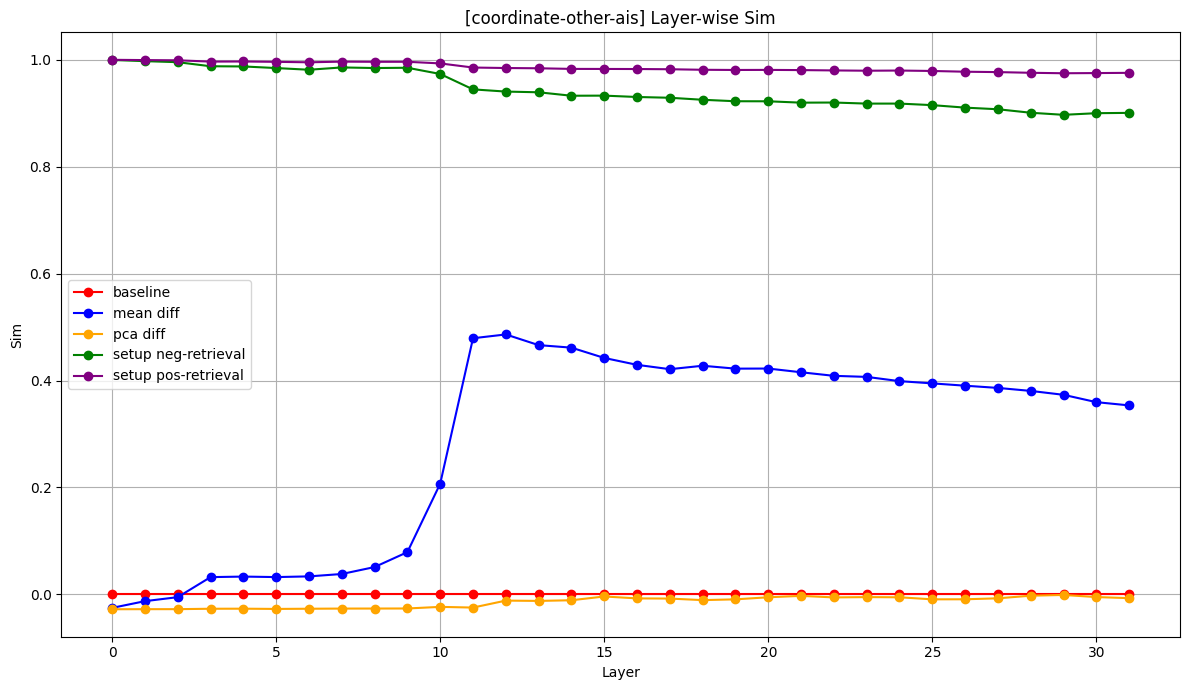

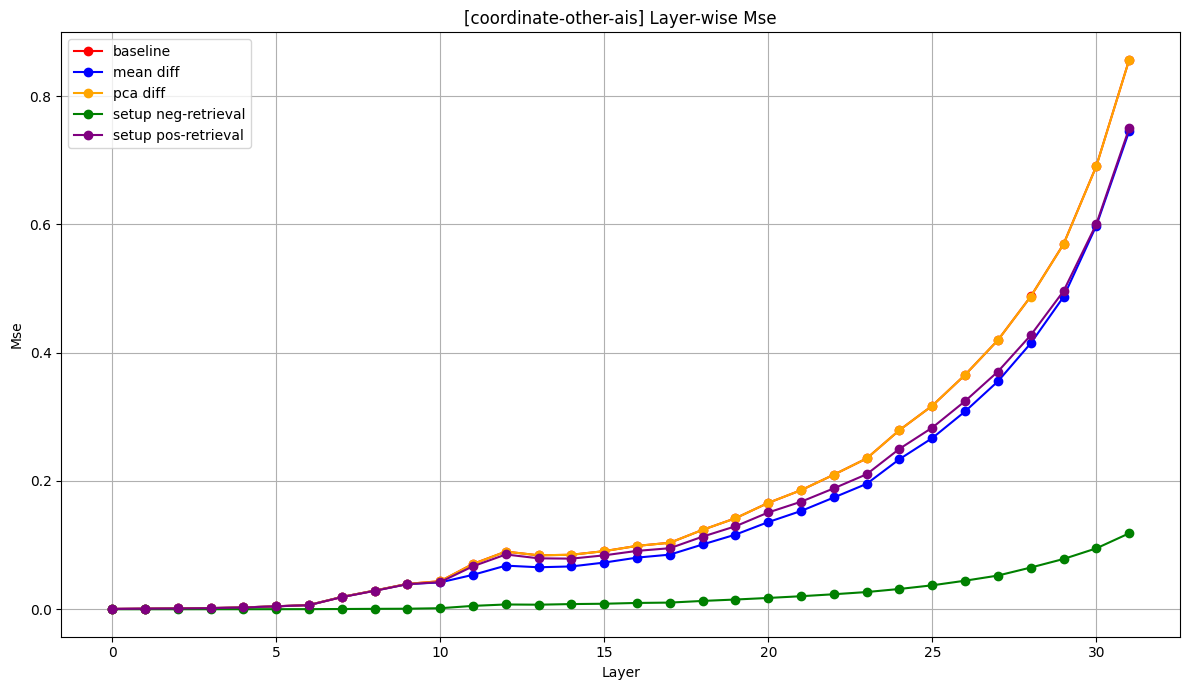

Running analyze on layer 0
train count: 232
test count: 58

Analyzing corrigible-neutral-HHH, layer 0
[Baseline] Dev MSE: 0.0005
[Mean Difference] Dev MSE: 0.0005, CosSim: -0.0689
[PCA coeff -2] Dev MSE: 0.0016, CosSim: -0.0689
[PCA coeff -1] Dev MSE: 0.0008, CosSim: -0.0689
[PCA coeff +0] Dev MSE: 0.0005, CosSim: 0.0000
[PCA coeff +1] Dev MSE: 0.0007, CosSim: 0.0689
[PCA coeff +2] Dev MSE: 0.0014, CosSim: 0.0689
[Retrieval diff transfer k=1] Dev MSE = 0.0000, CosSim = 0.9997
[Retrieval diff transfer k=3] Dev MSE = 0.0000, CosSim = 0.9998
[Retrieval diff transfer k=5] Dev MSE = 0.0000, CosSim = 0.9998
[Retrieval diff transfer k=10] Dev MSE = 0.0000, CosSim = 0.9998
[Retrieval diff transfer k=20] Dev MSE = 0.0000, CosSim = 0.9997
[neg-retrieval k=1] Dev MSE = 0.0000, CosSim = 0.9997
[neg-retrieval k=3] Dev MSE = 0.0000, CosSim = 0.9998
[neg-retrieval k=5] Dev MSE = 0.0000, CosSim = 0.9998
[neg-retrieval k=10] Dev MSE = 0.0000, CosSim = 0.9998
[pos-retrieval k=1] Dev MSE = 0.0005, CosSim

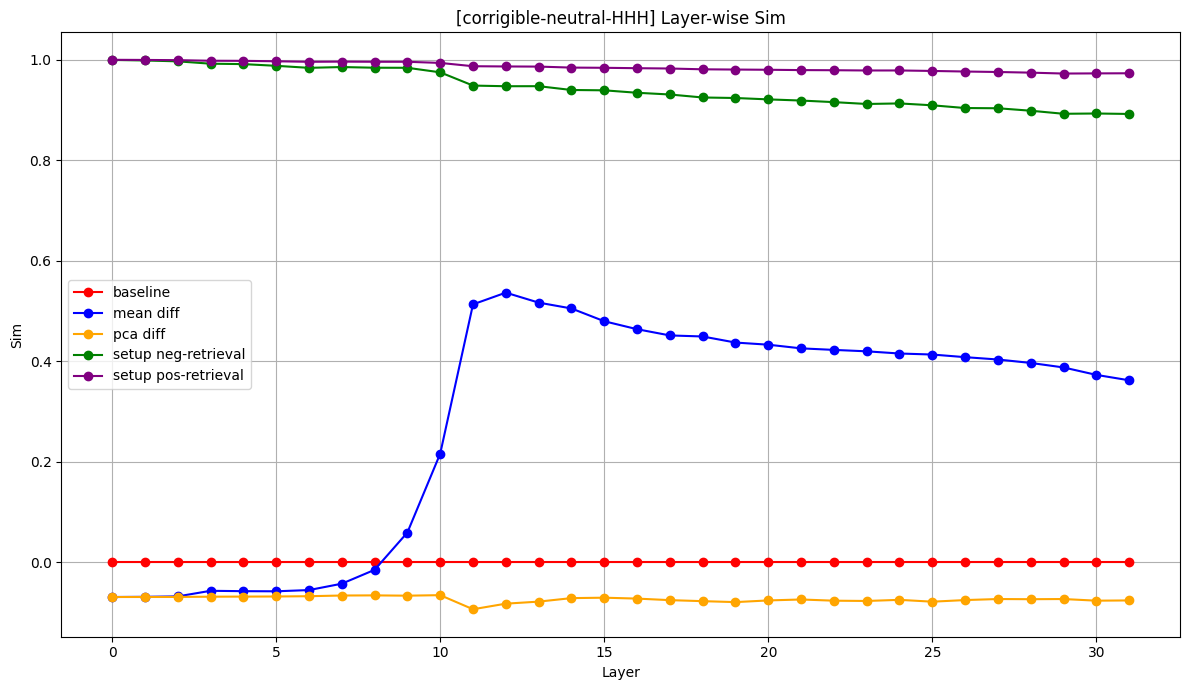

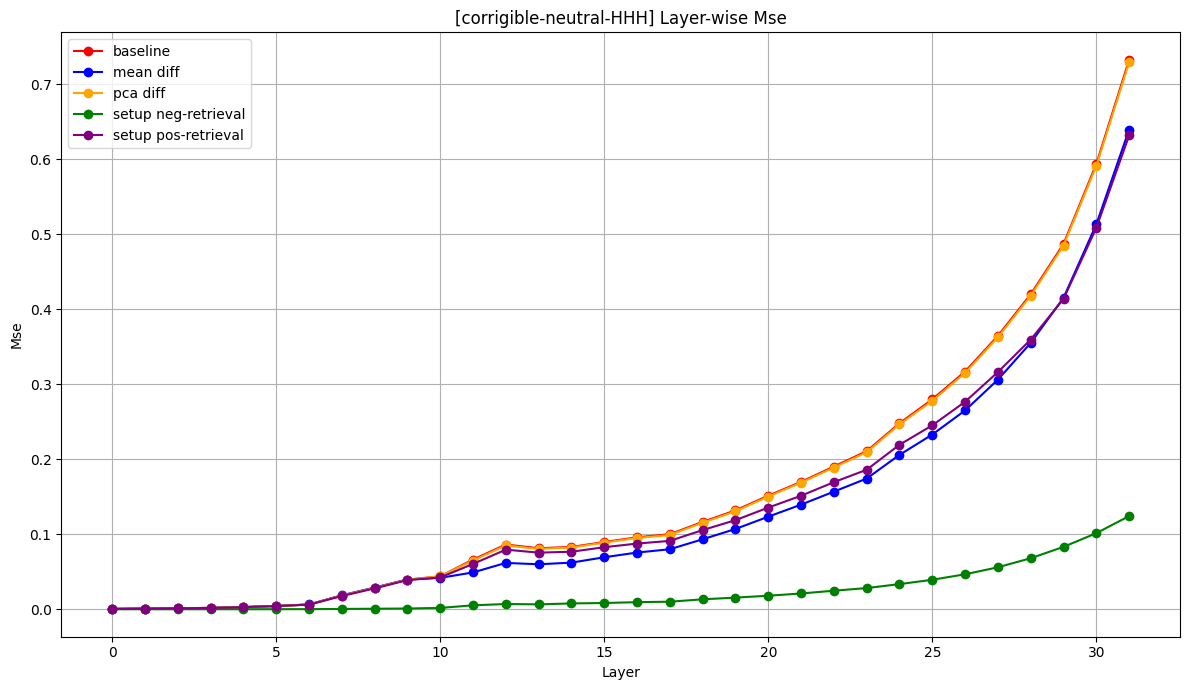

Running analyze on layer 0
train count: 800
test count: 200

Analyzing hallucination, layer 0
[Baseline] Dev MSE: 0.0005
[Mean Difference] Dev MSE: 0.0005, CosSim: -0.0077
[PCA coeff -2] Dev MSE: 0.0013, CosSim: 0.1197
[PCA coeff -1] Dev MSE: 0.0006, CosSim: 0.1197
[PCA coeff +0] Dev MSE: 0.0005, CosSim: 0.0000
[PCA coeff +1] Dev MSE: 0.0008, CosSim: -0.1197
[PCA coeff +2] Dev MSE: 0.0016, CosSim: -0.1197
[Retrieval diff transfer k=1] Dev MSE = 0.0000, CosSim = 0.9988
[Retrieval diff transfer k=3] Dev MSE = 0.0000, CosSim = 0.9992
[Retrieval diff transfer k=5] Dev MSE = 0.0000, CosSim = 0.9992
[Retrieval diff transfer k=10] Dev MSE = 0.0000, CosSim = 0.9992
[Retrieval diff transfer k=20] Dev MSE = 0.0000, CosSim = 0.9992
[neg-retrieval k=1] Dev MSE = 0.0000, CosSim = 0.9988
[neg-retrieval k=3] Dev MSE = 0.0000, CosSim = 0.9992
[neg-retrieval k=5] Dev MSE = 0.0000, CosSim = 0.9992
[neg-retrieval k=10] Dev MSE = 0.0000, CosSim = 0.9992
[pos-retrieval k=1] Dev MSE = 0.0005, CosSim = 0.999

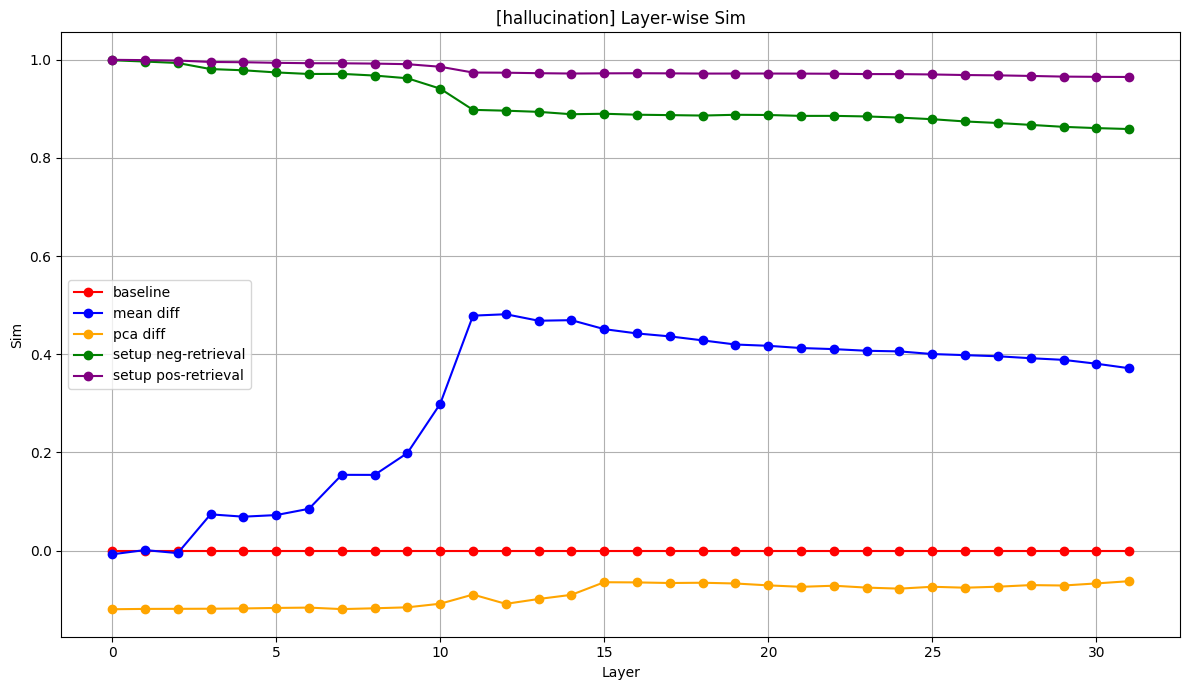

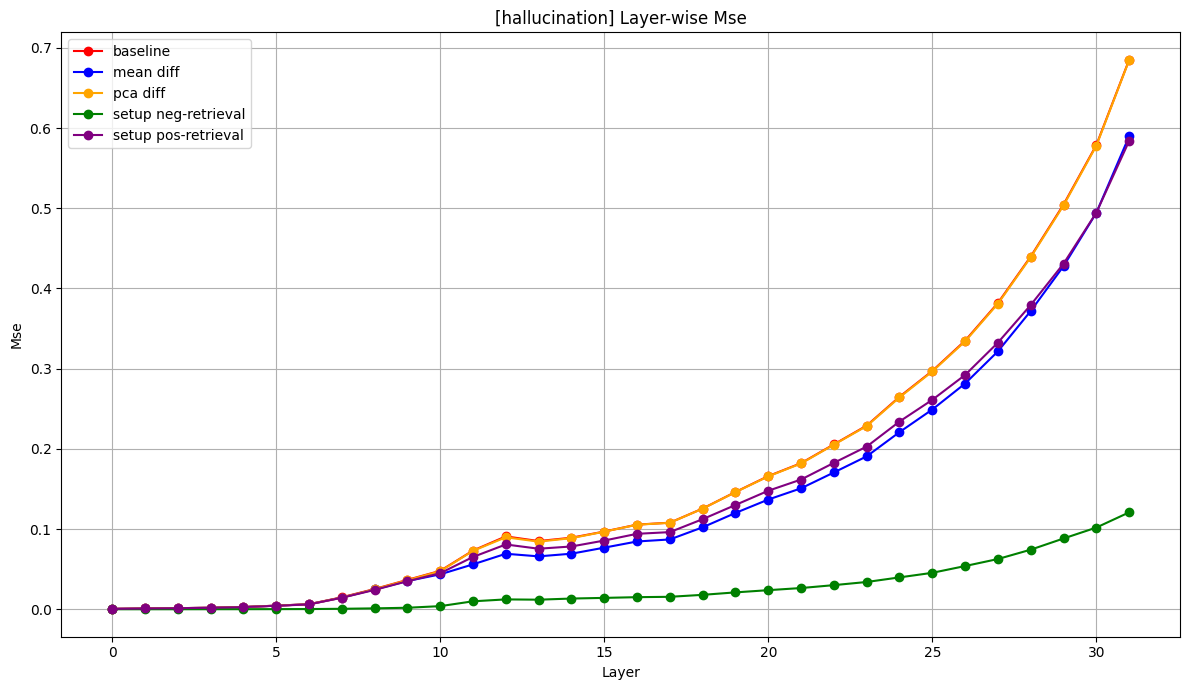

Running analyze on layer 0
train count: 760
test count: 190

Analyzing myopic-reward, layer 0
[Baseline] Dev MSE: 0.0005
[Mean Difference] Dev MSE: 0.0005, CosSim: 0.0178
[PCA coeff -2] Dev MSE: 0.0015, CosSim: -0.0526
[PCA coeff -1] Dev MSE: 0.0008, CosSim: -0.0526
[PCA coeff +0] Dev MSE: 0.0005, CosSim: 0.0000
[PCA coeff +1] Dev MSE: 0.0007, CosSim: 0.0526
[PCA coeff +2] Dev MSE: 0.0014, CosSim: 0.0526
[Retrieval diff transfer k=1] Dev MSE = 0.0000, CosSim = 0.9995
[Retrieval diff transfer k=3] Dev MSE = 0.0000, CosSim = 0.9996
[Retrieval diff transfer k=5] Dev MSE = 0.0000, CosSim = 0.9996
[Retrieval diff transfer k=10] Dev MSE = 0.0000, CosSim = 0.9996
[Retrieval diff transfer k=20] Dev MSE = 0.0000, CosSim = 0.9996
[neg-retrieval k=1] Dev MSE = 0.0000, CosSim = 0.9995
[neg-retrieval k=3] Dev MSE = 0.0000, CosSim = 0.9996
[neg-retrieval k=5] Dev MSE = 0.0000, CosSim = 0.9996
[neg-retrieval k=10] Dev MSE = 0.0000, CosSim = 0.9996
[pos-retrieval k=1] Dev MSE = 0.0005, CosSim = 0.9999

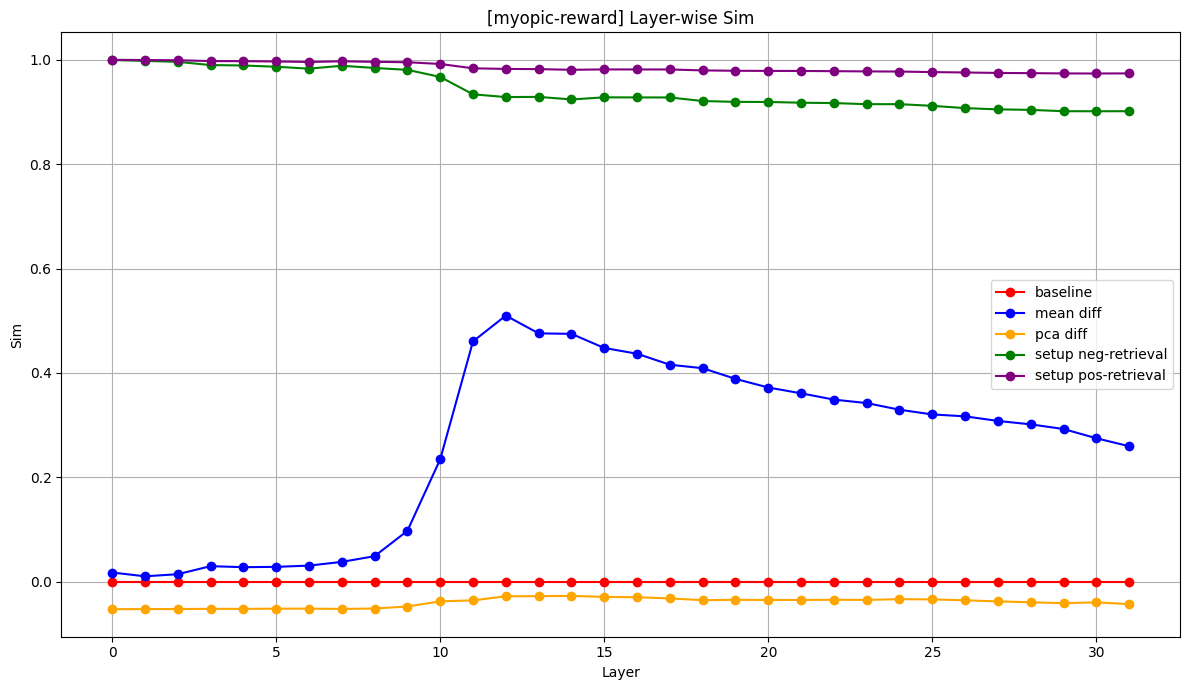

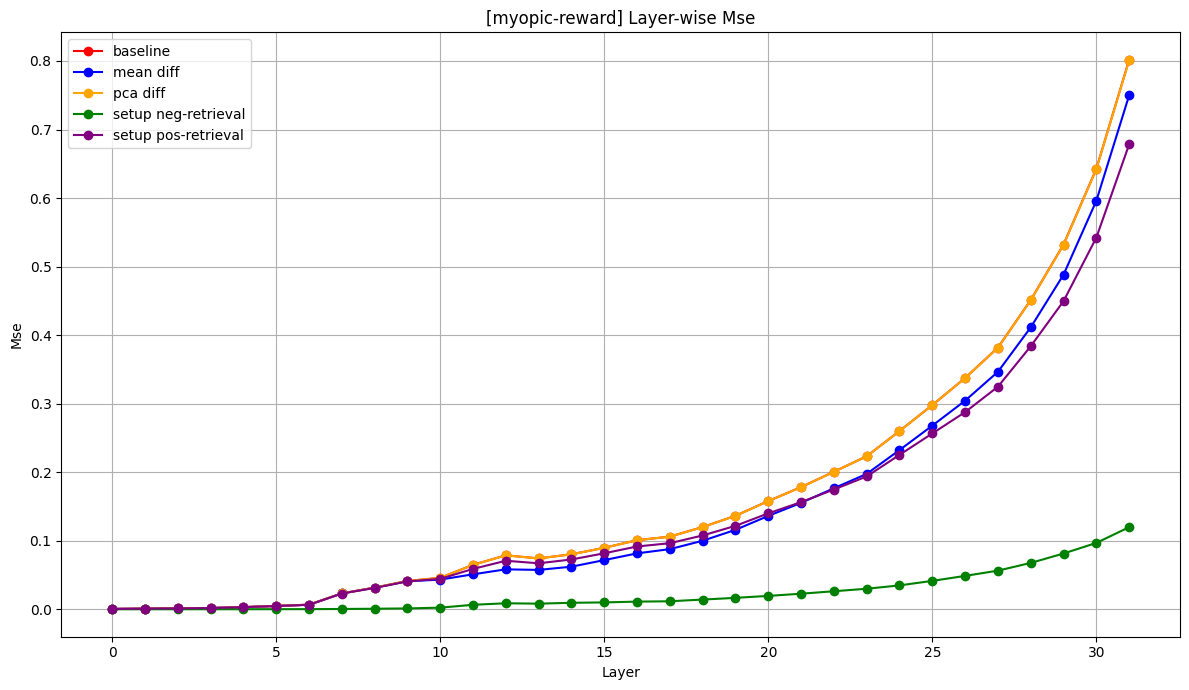

Running analyze on layer 0
train count: 722
test count: 181

Analyzing survival-instinct, layer 0
[Baseline] Dev MSE: 0.0005
[Mean Difference] Dev MSE: 0.0004, CosSim: 0.3685
[PCA coeff -2] Dev MSE: 0.0010, CosSim: 0.3615
[PCA coeff -1] Dev MSE: 0.0005, CosSim: 0.3615
[PCA coeff +0] Dev MSE: 0.0005, CosSim: 0.0000
[PCA coeff +1] Dev MSE: 0.0010, CosSim: -0.3615
[PCA coeff +2] Dev MSE: 0.0020, CosSim: -0.3615
[Retrieval diff transfer k=1] Dev MSE = 0.0001, CosSim = 0.9417
[Retrieval diff transfer k=3] Dev MSE = 0.0000, CosSim = 0.9580
[Retrieval diff transfer k=5] Dev MSE = 0.0000, CosSim = 0.9586
[Retrieval diff transfer k=10] Dev MSE = 0.0000, CosSim = 0.9645
[Retrieval diff transfer k=20] Dev MSE = 0.0000, CosSim = 0.9686
[neg-retrieval k=1] Dev MSE = 0.0001, CosSim = 0.9417
[neg-retrieval k=3] Dev MSE = 0.0000, CosSim = 0.9580
[neg-retrieval k=5] Dev MSE = 0.0000, CosSim = 0.9586
[neg-retrieval k=10] Dev MSE = 0.0000, CosSim = 0.9645
[pos-retrieval k=1] Dev MSE = 0.0005, CosSim = 0.

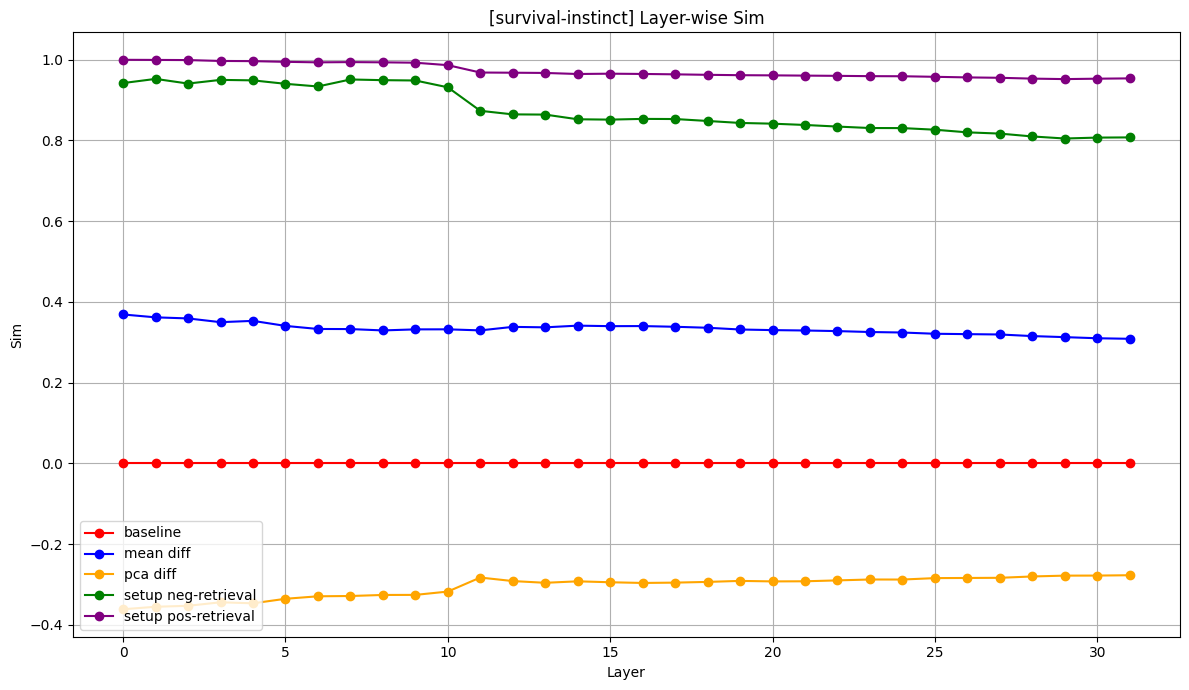

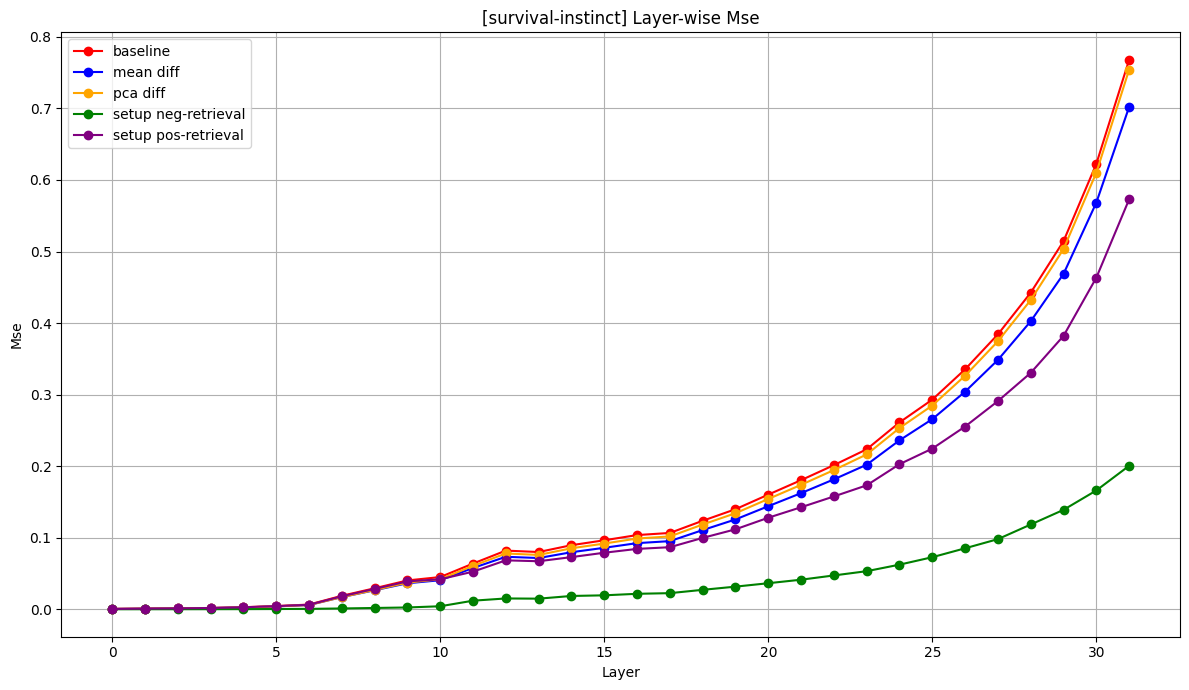

Running analyze on layer 0
train count: 800
test count: 200

Analyzing sycophancy, layer 0
[Baseline] Dev MSE: 0.0005
[Mean Difference] Dev MSE: 0.0005, CosSim: -0.1394
[PCA coeff -2] Dev MSE: 0.0013, CosSim: 0.1398
[PCA coeff -1] Dev MSE: 0.0006, CosSim: 0.1398
[PCA coeff +0] Dev MSE: 0.0005, CosSim: 0.0000
[PCA coeff +1] Dev MSE: 0.0008, CosSim: -0.1398
[PCA coeff +2] Dev MSE: 0.0016, CosSim: -0.1398
[Retrieval diff transfer k=1] Dev MSE = 0.0000, CosSim = 0.9999
[Retrieval diff transfer k=3] Dev MSE = 0.0000, CosSim = 0.9999
[Retrieval diff transfer k=5] Dev MSE = 0.0000, CosSim = 0.9999
[Retrieval diff transfer k=10] Dev MSE = 0.0000, CosSim = 0.9999
[Retrieval diff transfer k=20] Dev MSE = 0.0000, CosSim = 0.9998
[neg-retrieval k=1] Dev MSE = 0.0000, CosSim = 0.9999
[neg-retrieval k=3] Dev MSE = 0.0000, CosSim = 0.9999
[neg-retrieval k=5] Dev MSE = 0.0000, CosSim = 0.9999
[neg-retrieval k=10] Dev MSE = 0.0000, CosSim = 0.9999
[pos-retrieval k=1] Dev MSE = 0.0005, CosSim = 1.0000
[

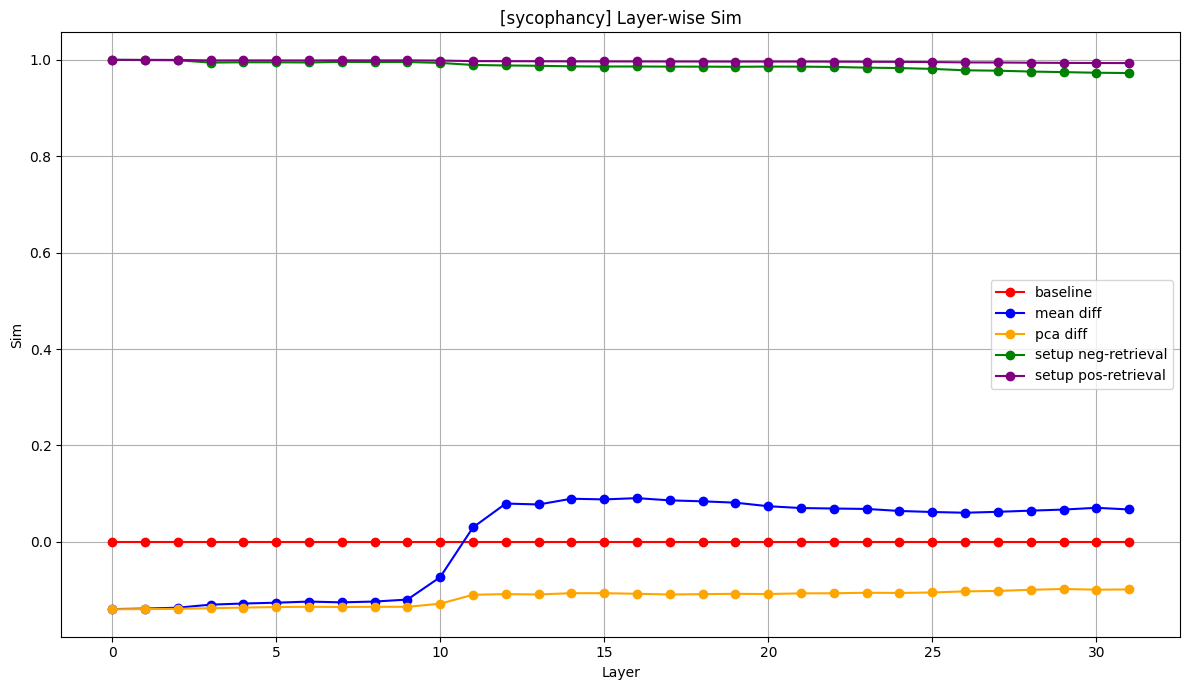

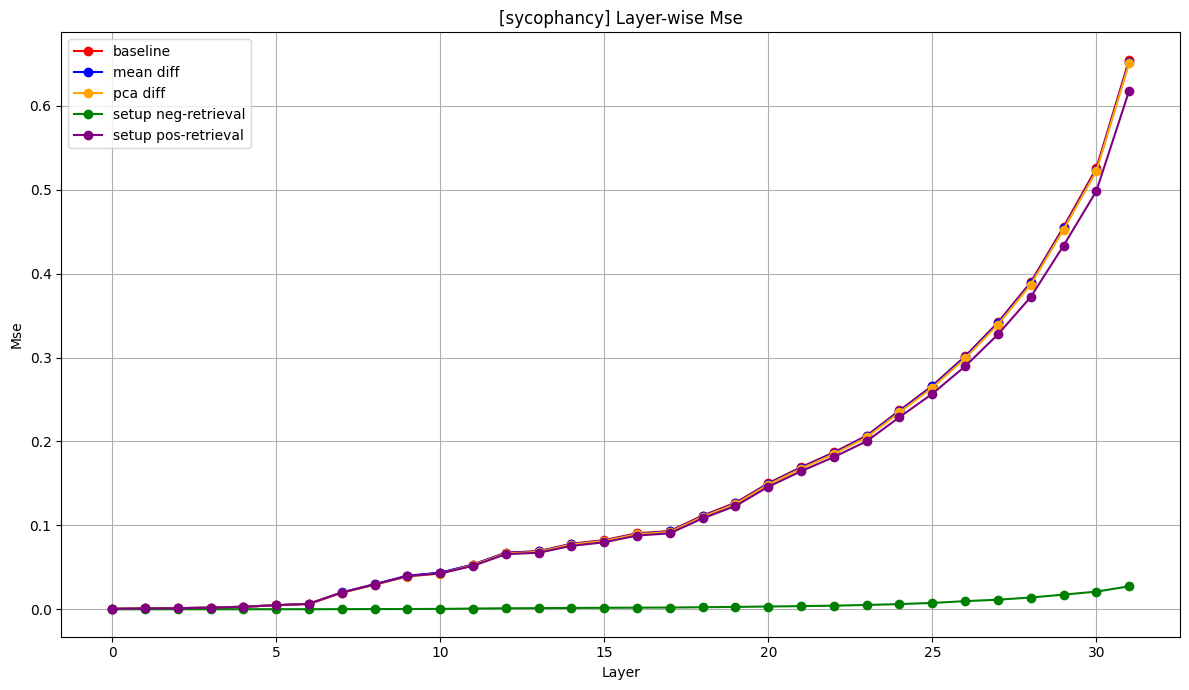

Running analyze on layer 0
train count: 326
test count: 82

Analyzing refusal, layer 0
[Baseline] Dev MSE: 0.0005
[Mean Difference] Dev MSE: 0.0005, CosSim: 0.0488
[PCA coeff -2] Dev MSE: 0.0015, CosSim: -0.0489
[PCA coeff -1] Dev MSE: 0.0008, CosSim: -0.0489
[PCA coeff +0] Dev MSE: 0.0005, CosSim: 0.0000
[PCA coeff +1] Dev MSE: 0.0007, CosSim: 0.0489
[PCA coeff +2] Dev MSE: 0.0014, CosSim: 0.0489
[Retrieval diff transfer k=1] Dev MSE = 0.0000, CosSim = 0.9991
[Retrieval diff transfer k=3] Dev MSE = 0.0000, CosSim = 0.9993
[Retrieval diff transfer k=5] Dev MSE = 0.0000, CosSim = 0.9993
[Retrieval diff transfer k=10] Dev MSE = 0.0000, CosSim = 0.9993
[Retrieval diff transfer k=20] Dev MSE = 0.0000, CosSim = 0.9993
[neg-retrieval k=1] Dev MSE = 0.0000, CosSim = 0.9991
[neg-retrieval k=3] Dev MSE = 0.0000, CosSim = 0.9993
[neg-retrieval k=5] Dev MSE = 0.0000, CosSim = 0.9993
[neg-retrieval k=10] Dev MSE = 0.0000, CosSim = 0.9993
[pos-retrieval k=1] Dev MSE = 0.0005, CosSim = 0.9998
[pos-r

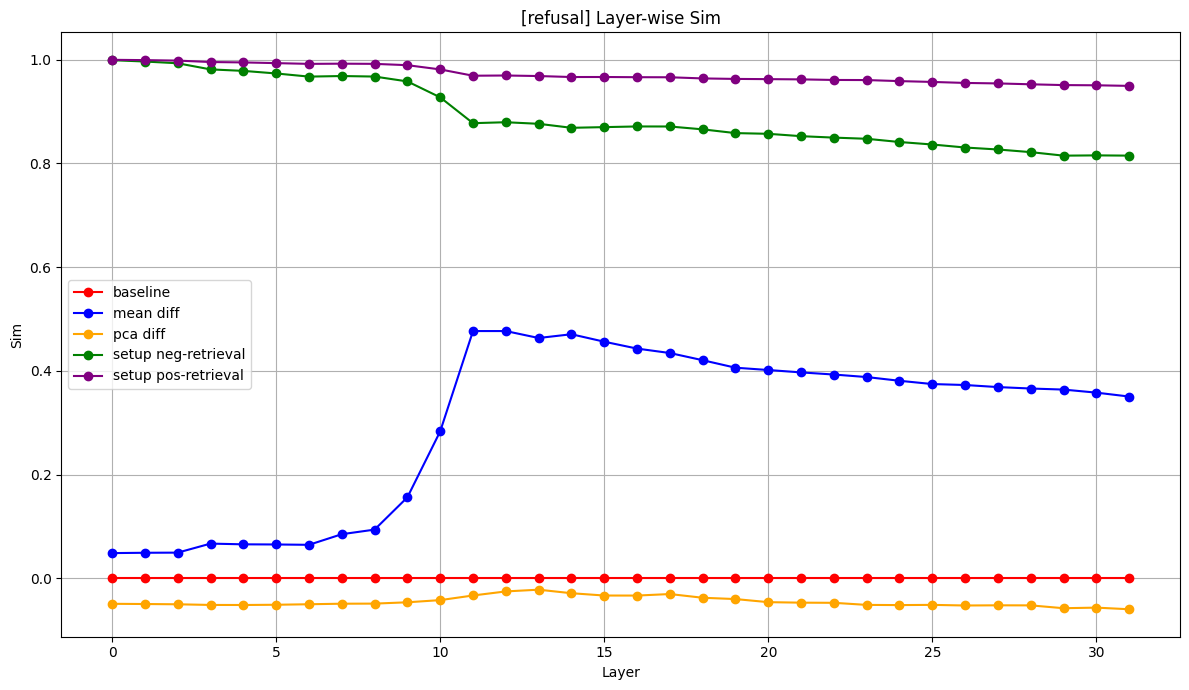

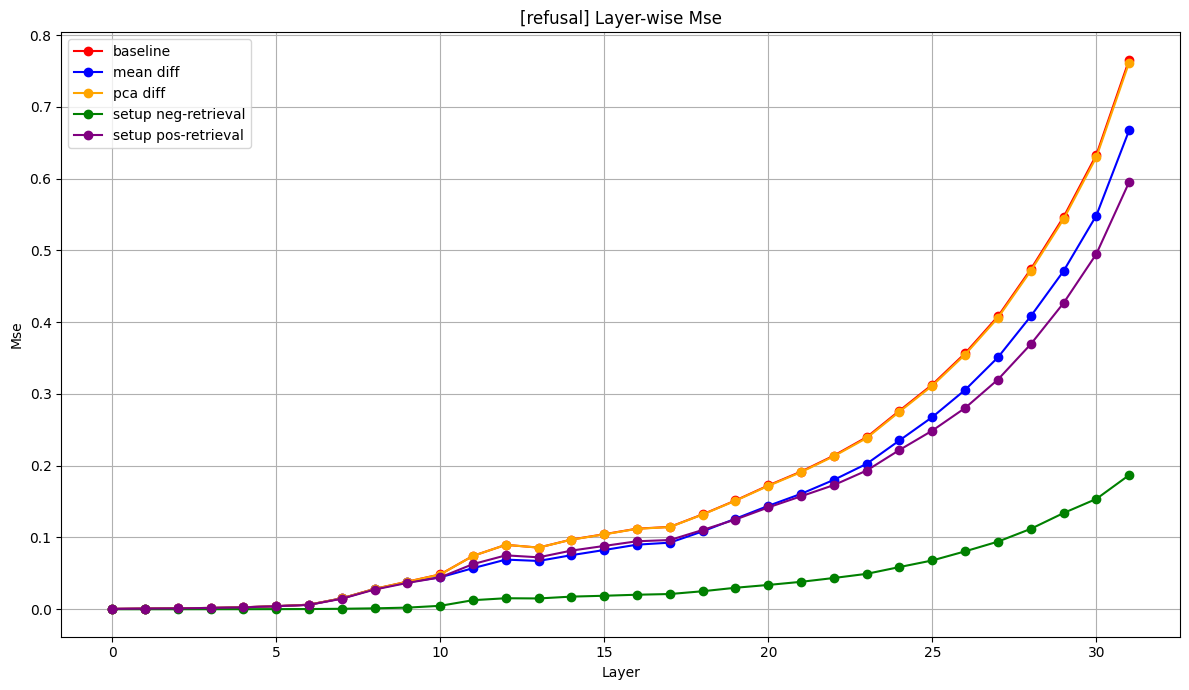

Running analyze on layer 0
train count: 585
test count: 147

Analyzing multiwozdst_choice, layer 0
[Baseline] Dev MSE: 0.0005
[Mean Difference] Dev MSE: 0.0005, CosSim: 0.0712
[PCA coeff -2] Dev MSE: 0.0014, CosSim: 0.0748
[PCA coeff -1] Dev MSE: 0.0007, CosSim: 0.0748
[PCA coeff +0] Dev MSE: 0.0005, CosSim: 0.0000
[PCA coeff +1] Dev MSE: 0.0008, CosSim: -0.0748
[PCA coeff +2] Dev MSE: 0.0016, CosSim: -0.0748
[Retrieval diff transfer k=1] Dev MSE = 0.0000, CosSim = 0.9998
[Retrieval diff transfer k=3] Dev MSE = 0.0000, CosSim = 0.9998
[Retrieval diff transfer k=5] Dev MSE = 0.0000, CosSim = 0.9999
[Retrieval diff transfer k=10] Dev MSE = 0.0000, CosSim = 0.9998
[Retrieval diff transfer k=20] Dev MSE = 0.0000, CosSim = 0.9998
[neg-retrieval k=1] Dev MSE = 0.0000, CosSim = 0.9998
[neg-retrieval k=3] Dev MSE = 0.0000, CosSim = 0.9998
[neg-retrieval k=5] Dev MSE = 0.0000, CosSim = 0.9999
[neg-retrieval k=10] Dev MSE = 0.0000, CosSim = 0.9998
[pos-retrieval k=1] Dev MSE = 0.0005, CosSim = 0

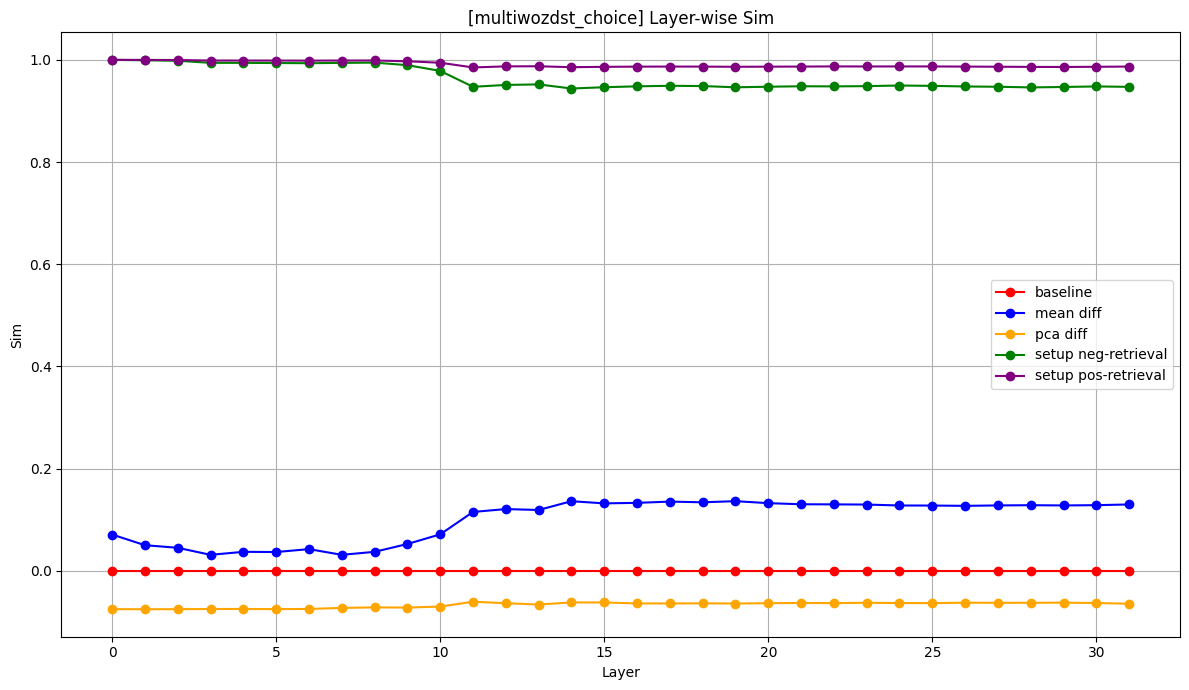

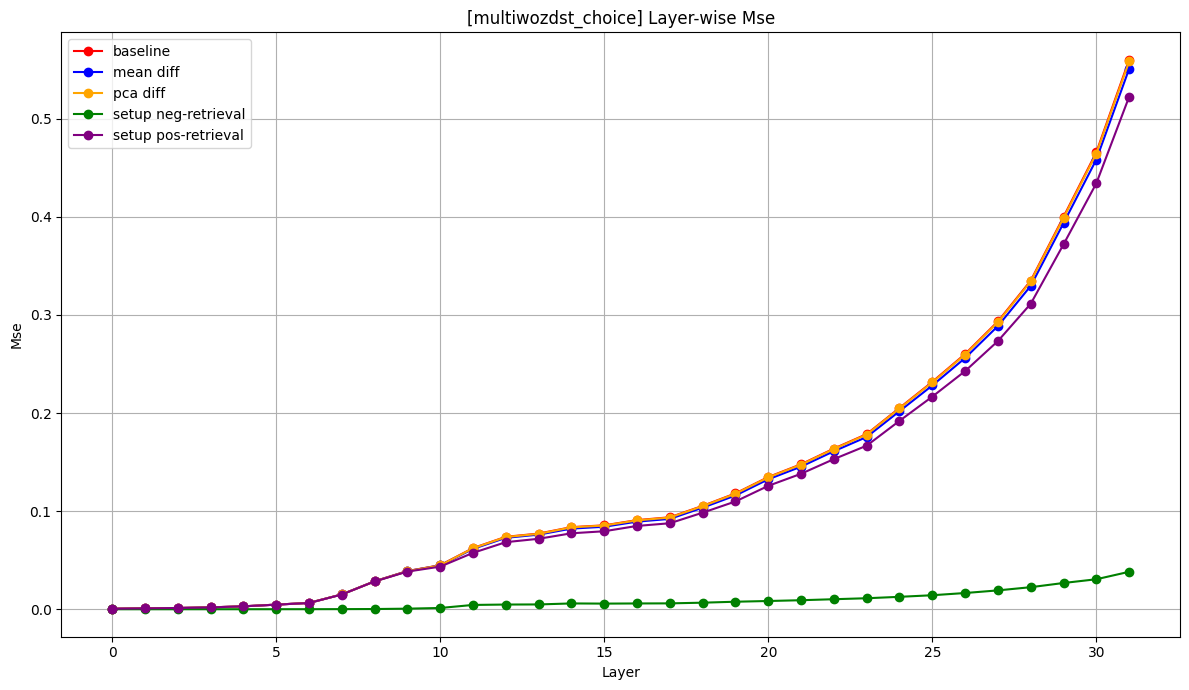

Running analyze on layer 0
train count: 240
test count: 60

Analyzing paradetox_choice, layer 0
[Baseline] Dev MSE: 0.0005
[Mean Difference] Dev MSE: 0.0005, CosSim: -0.0995
[PCA coeff -2] Dev MSE: 0.0016, CosSim: -0.0999
[PCA coeff -1] Dev MSE: 0.0008, CosSim: -0.0999
[PCA coeff +0] Dev MSE: 0.0005, CosSim: 0.0000
[PCA coeff +1] Dev MSE: 0.0007, CosSim: 0.0999
[PCA coeff +2] Dev MSE: 0.0013, CosSim: 0.0999
[Retrieval diff transfer k=1] Dev MSE = 0.0000, CosSim = 0.9989
[Retrieval diff transfer k=3] Dev MSE = 0.0000, CosSim = 0.9993
[Retrieval diff transfer k=5] Dev MSE = 0.0000, CosSim = 0.9994
[Retrieval diff transfer k=10] Dev MSE = 0.0000, CosSim = 0.9994
[Retrieval diff transfer k=20] Dev MSE = 0.0000, CosSim = 0.9993
[neg-retrieval k=1] Dev MSE = 0.0000, CosSim = 0.9989
[neg-retrieval k=3] Dev MSE = 0.0000, CosSim = 0.9993
[neg-retrieval k=5] Dev MSE = 0.0000, CosSim = 0.9994
[neg-retrieval k=10] Dev MSE = 0.0000, CosSim = 0.9994
[pos-retrieval k=1] Dev MSE = 0.0005, CosSim = 0.9

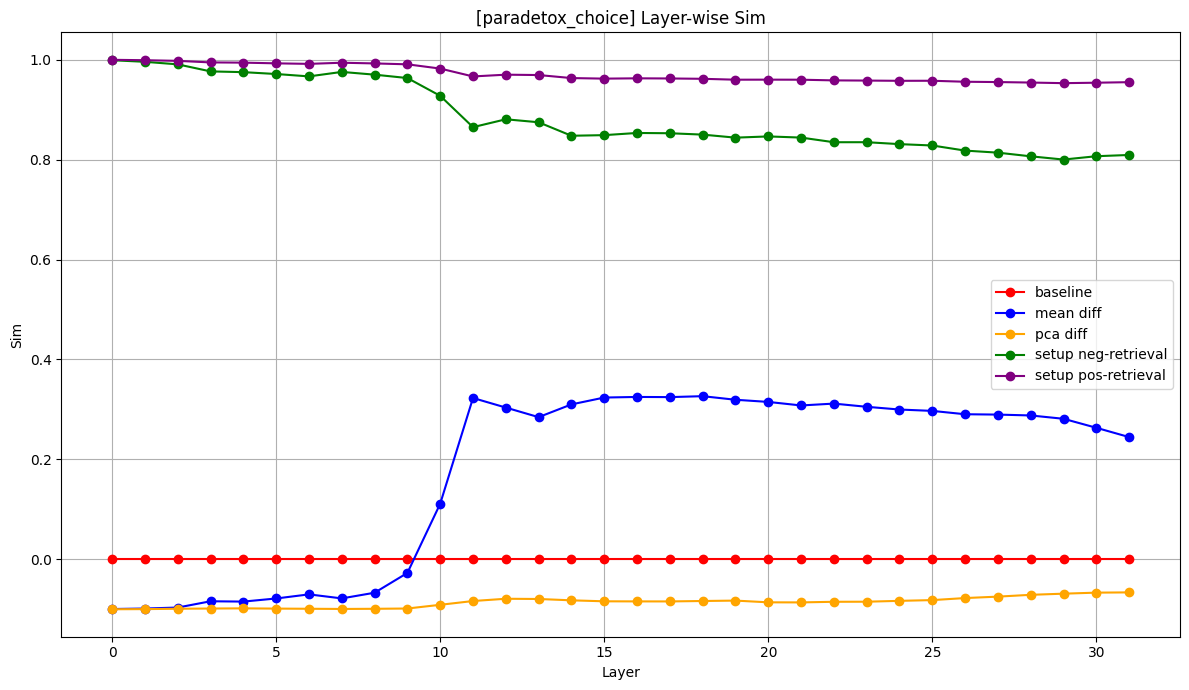

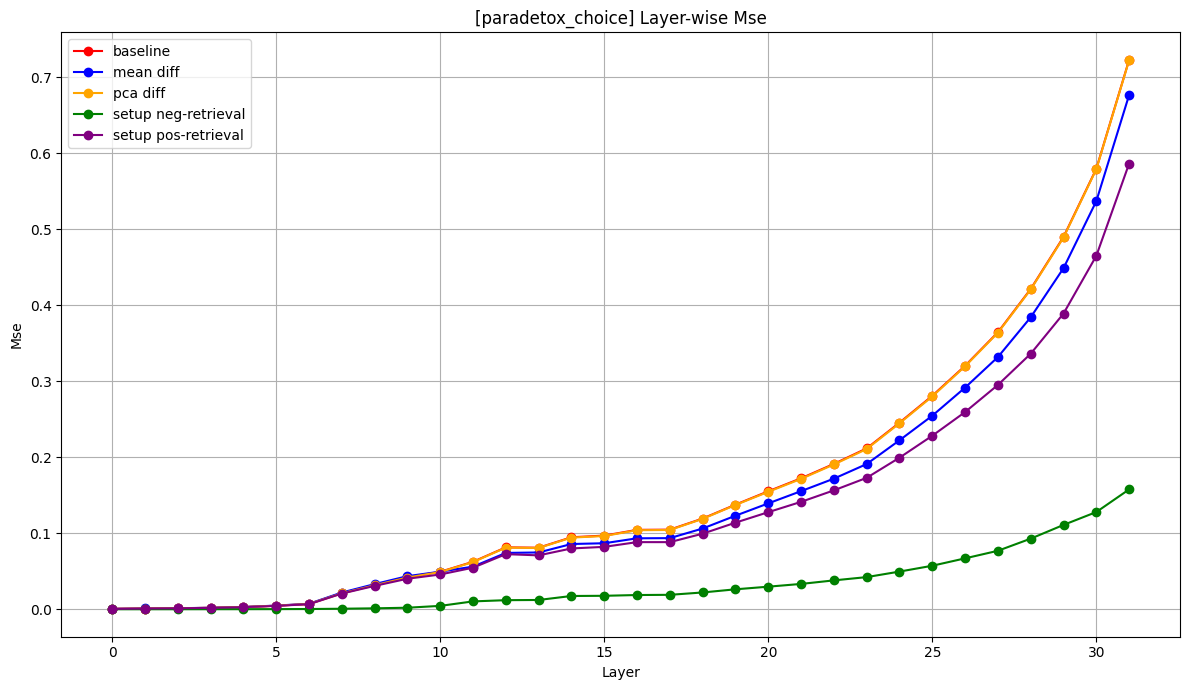

Running analyze on layer 0
train count: 5454
test count: 1364

Analyzing commonsense_qa, layer 0
[Baseline] Dev MSE: 0.0005
[Mean Difference] Dev MSE: 0.0005, CosSim: 0.0132
[PCA coeff -2] Dev MSE: 0.0015, CosSim: -0.0132
[PCA coeff -1] Dev MSE: 0.0007, CosSim: -0.0132
[PCA coeff +0] Dev MSE: 0.0005, CosSim: 0.0000
[PCA coeff +1] Dev MSE: 0.0007, CosSim: 0.0132
[PCA coeff +2] Dev MSE: 0.0014, CosSim: 0.0132
[Retrieval diff transfer k=1] Dev MSE = 0.0000, CosSim = 0.9997
[Retrieval diff transfer k=3] Dev MSE = 0.0000, CosSim = 0.9998
[Retrieval diff transfer k=5] Dev MSE = 0.0000, CosSim = 0.9998
[Retrieval diff transfer k=10] Dev MSE = 0.0000, CosSim = 0.9998
[Retrieval diff transfer k=20] Dev MSE = 0.0000, CosSim = 0.9998
[neg-retrieval k=1] Dev MSE = 0.0000, CosSim = 0.9997
[neg-retrieval k=3] Dev MSE = 0.0000, CosSim = 0.9998
[neg-retrieval k=5] Dev MSE = 0.0000, CosSim = 0.9998
[neg-retrieval k=10] Dev MSE = 0.0000, CosSim = 0.9998
[pos-retrieval k=1] Dev MSE = 0.0005, CosSim = 0.9

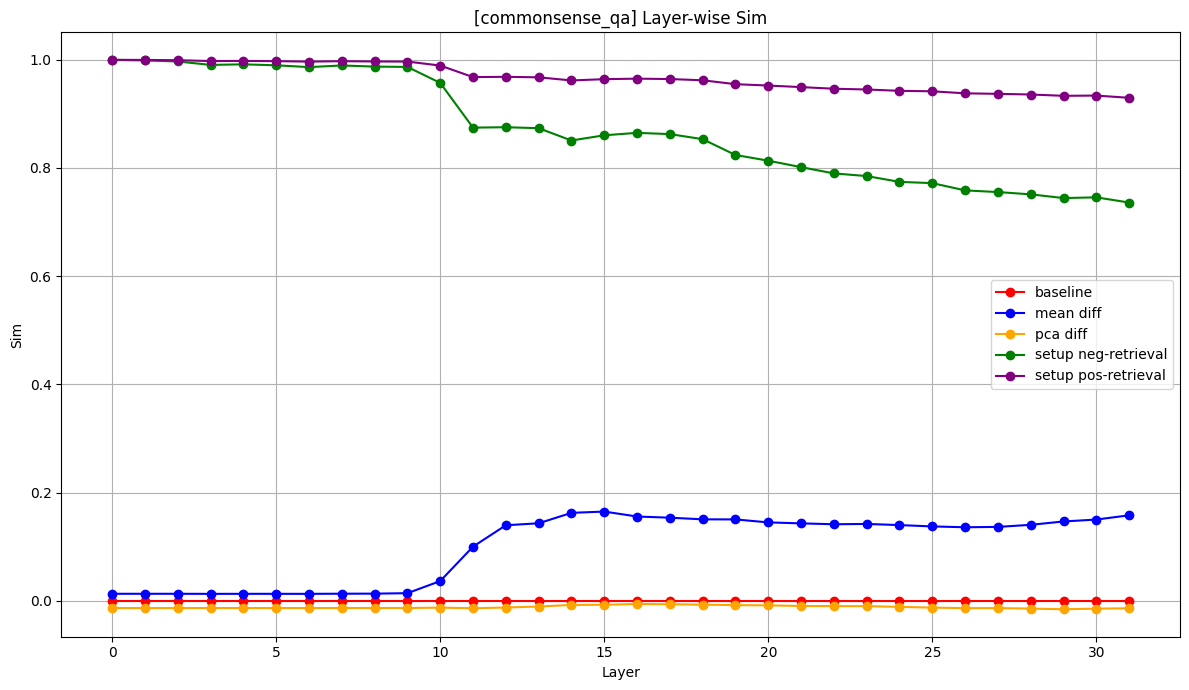

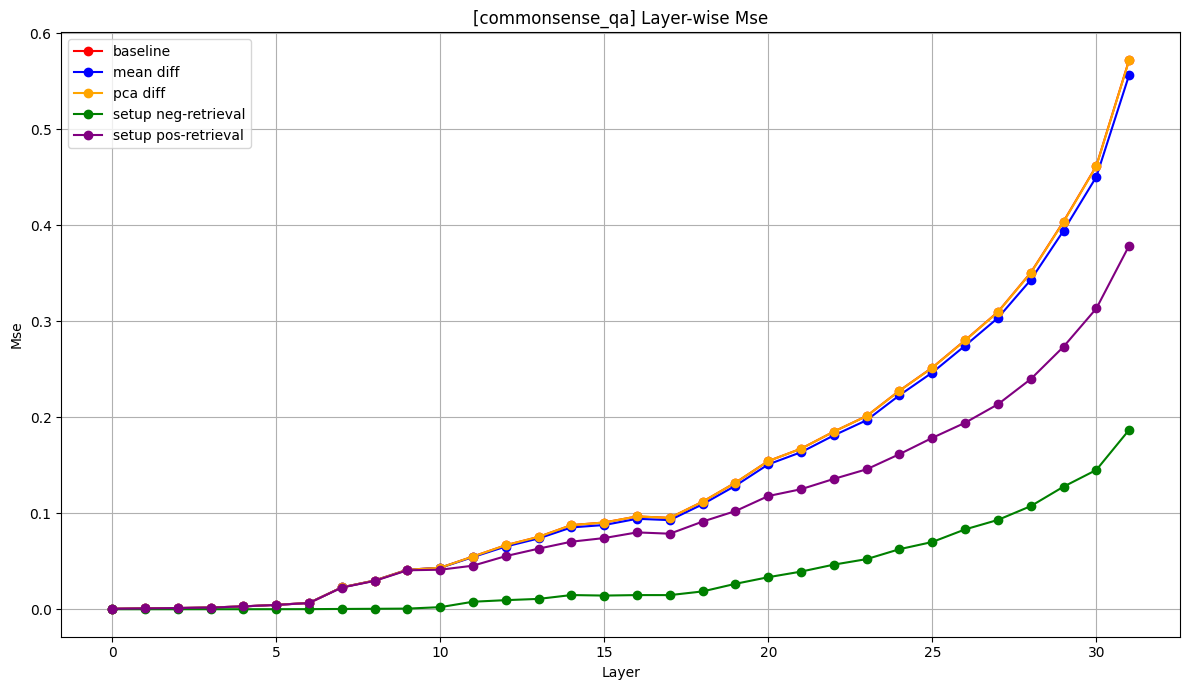

Running analyze on layer 0
train count: 3965
test count: 992

Analyzing openbookqa, layer 0
[Baseline] Dev MSE: 0.0005
[Mean Difference] Dev MSE: 0.0005, CosSim: 0.0201
[PCA coeff -2] Dev MSE: 0.0015, CosSim: -0.0201
[PCA coeff -1] Dev MSE: 0.0007, CosSim: -0.0201
[PCA coeff +0] Dev MSE: 0.0005, CosSim: 0.0000
[PCA coeff +1] Dev MSE: 0.0007, CosSim: 0.0201
[PCA coeff +2] Dev MSE: 0.0014, CosSim: 0.0201
[Retrieval diff transfer k=1] Dev MSE = 0.0000, CosSim = 0.9996
[Retrieval diff transfer k=3] Dev MSE = 0.0000, CosSim = 0.9998
[Retrieval diff transfer k=5] Dev MSE = 0.0000, CosSim = 0.9998
[Retrieval diff transfer k=10] Dev MSE = 0.0000, CosSim = 0.9998
[Retrieval diff transfer k=20] Dev MSE = 0.0000, CosSim = 0.9998
[neg-retrieval k=1] Dev MSE = 0.0000, CosSim = 0.9996
[neg-retrieval k=3] Dev MSE = 0.0000, CosSim = 0.9998
[neg-retrieval k=5] Dev MSE = 0.0000, CosSim = 0.9998
[neg-retrieval k=10] Dev MSE = 0.0000, CosSim = 0.9998
[pos-retrieval k=1] Dev MSE = 0.0005, CosSim = 0.9999
[

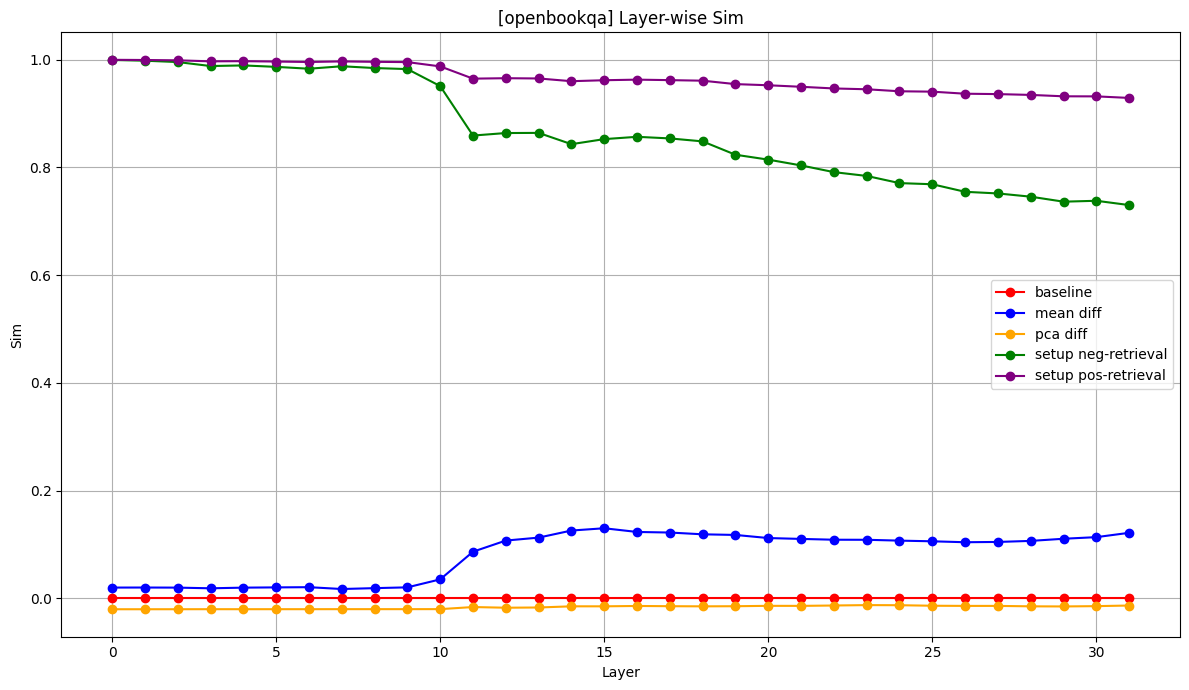

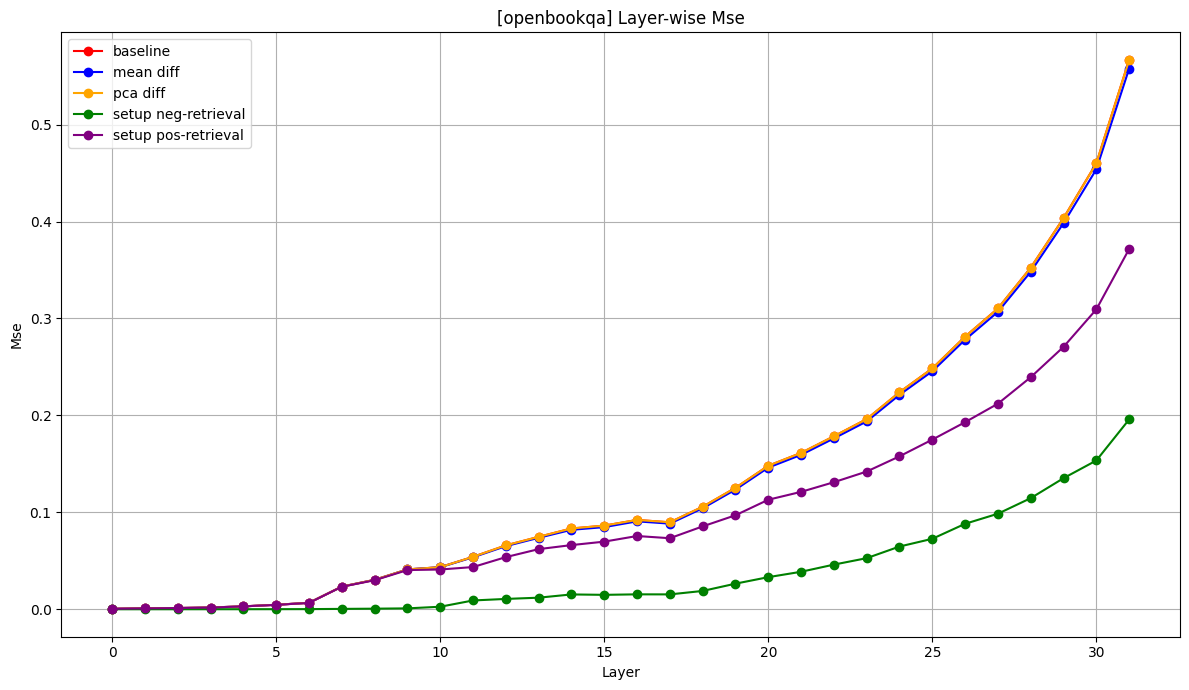

Running analyze on layer 0
train count: 102
test count: 26

Analyzing bbh_boolean_expressions, layer 0
[Baseline] Dev MSE: 0.0005
[Mean Difference] Dev MSE: 0.0006, CosSim: -0.2307
[PCA coeff -2] Dev MSE: 0.0012, CosSim: 0.2308
[PCA coeff -1] Dev MSE: 0.0006, CosSim: 0.2308
[PCA coeff +0] Dev MSE: 0.0005, CosSim: 0.0000
[PCA coeff +1] Dev MSE: 0.0009, CosSim: -0.2308
[PCA coeff +2] Dev MSE: 0.0018, CosSim: -0.2308
[Retrieval diff transfer k=1] Dev MSE = 0.0000, CosSim = 1.0000
[Retrieval diff transfer k=3] Dev MSE = 0.0000, CosSim = 1.0000
[Retrieval diff transfer k=5] Dev MSE = 0.0000, CosSim = 1.0000
[Retrieval diff transfer k=10] Dev MSE = 0.0000, CosSim = 1.0000
[Retrieval diff transfer k=20] Dev MSE = 0.0000, CosSim = 1.0000
[neg-retrieval k=1] Dev MSE = 0.0000, CosSim = 1.0000
[neg-retrieval k=3] Dev MSE = 0.0000, CosSim = 1.0000
[neg-retrieval k=5] Dev MSE = 0.0000, CosSim = 1.0000
[neg-retrieval k=10] Dev MSE = 0.0000, CosSim = 1.0000
[pos-retrieval k=1] Dev MSE = 0.0005, CosSi

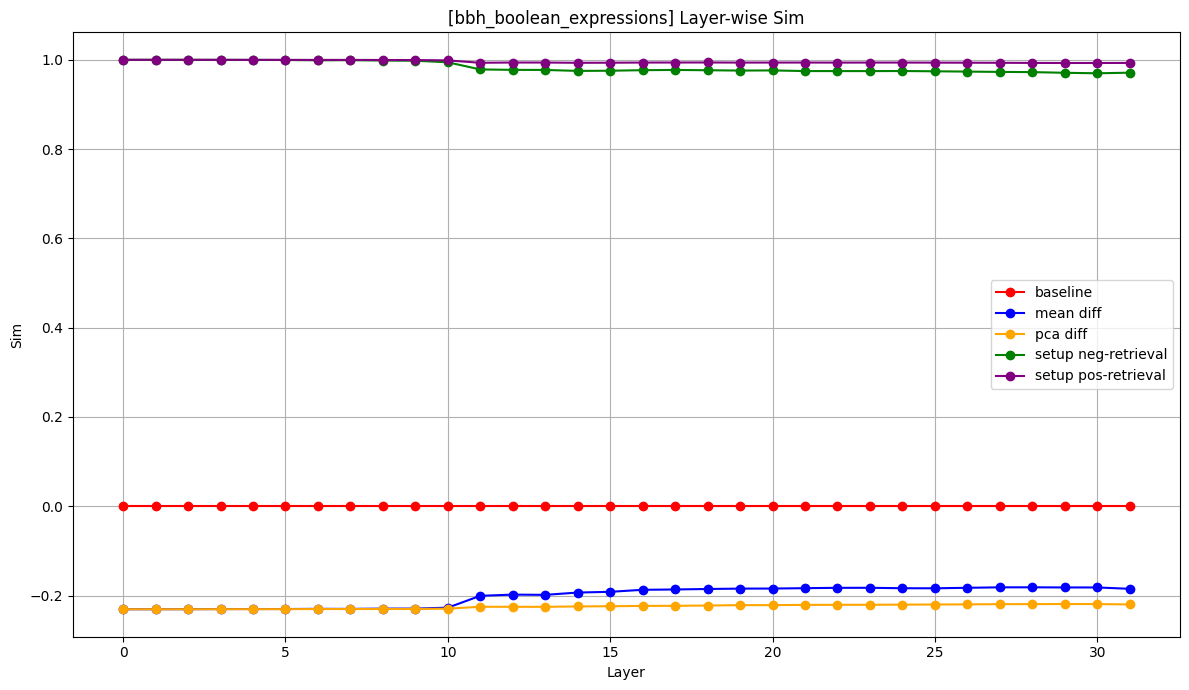

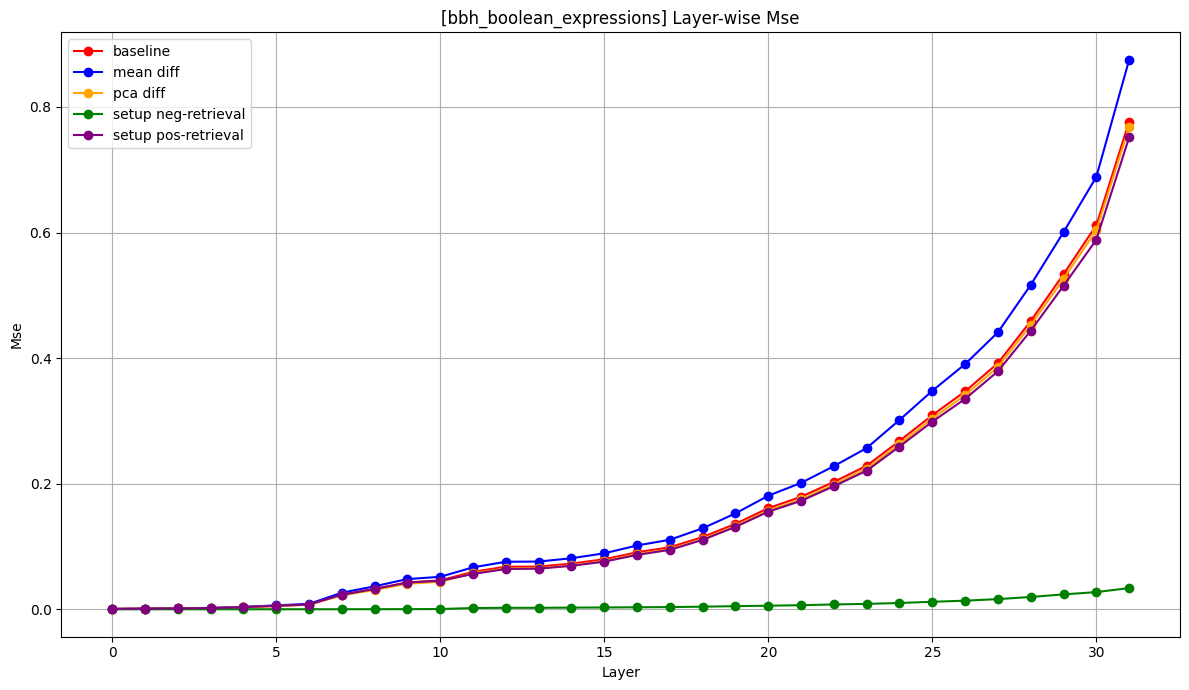

Running analyze on layer 0
train count: 102
test count: 26

Analyzing bbh_date_understanding, layer 0
[Baseline] Dev MSE: 0.0005
[Mean Difference] Dev MSE: 0.0005, CosSim: -0.0769
[PCA coeff -2] Dev MSE: 0.0014, CosSim: 0.0769
[PCA coeff -1] Dev MSE: 0.0007, CosSim: 0.0769
[PCA coeff +0] Dev MSE: 0.0005, CosSim: 0.0000
[PCA coeff +1] Dev MSE: 0.0008, CosSim: -0.0769
[PCA coeff +2] Dev MSE: 0.0016, CosSim: -0.0769
[Retrieval diff transfer k=1] Dev MSE = 0.0000, CosSim = 0.9999
[Retrieval diff transfer k=3] Dev MSE = 0.0000, CosSim = 0.9999
[Retrieval diff transfer k=5] Dev MSE = 0.0000, CosSim = 0.9999
[Retrieval diff transfer k=10] Dev MSE = 0.0000, CosSim = 0.9999
[Retrieval diff transfer k=20] Dev MSE = 0.0000, CosSim = 0.9999
[neg-retrieval k=1] Dev MSE = 0.0000, CosSim = 0.9999
[neg-retrieval k=3] Dev MSE = 0.0000, CosSim = 0.9999
[neg-retrieval k=5] Dev MSE = 0.0000, CosSim = 0.9999
[neg-retrieval k=10] Dev MSE = 0.0000, CosSim = 0.9999
[pos-retrieval k=1] Dev MSE = 0.0005, CosSim

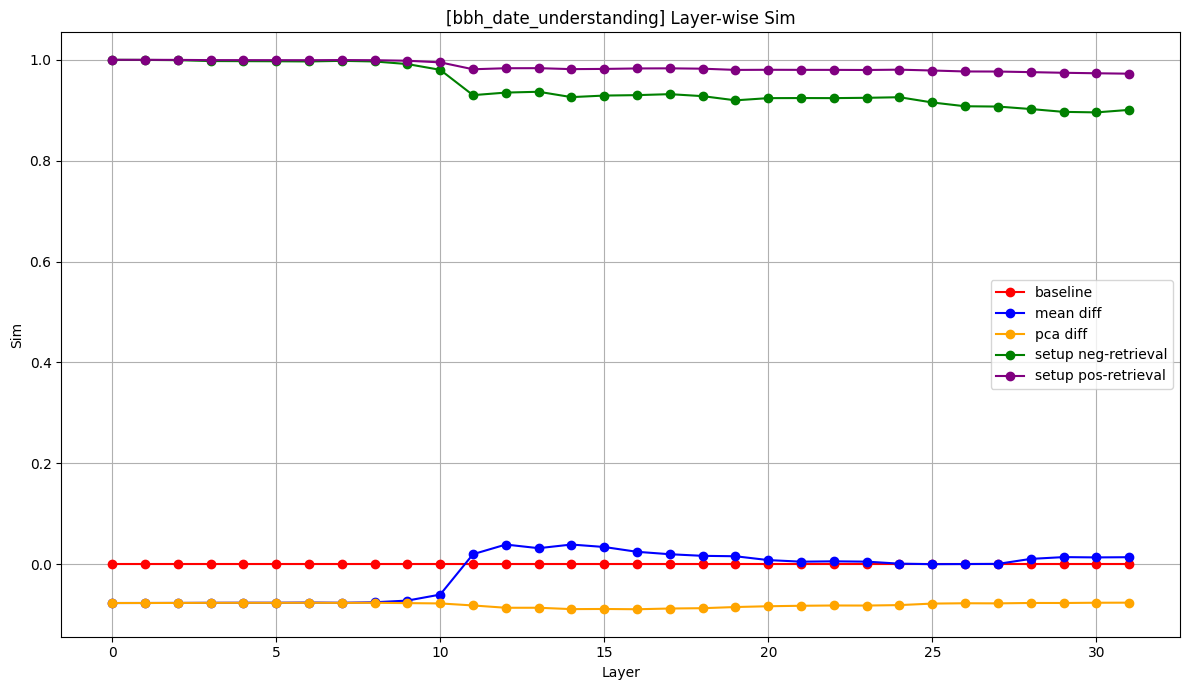

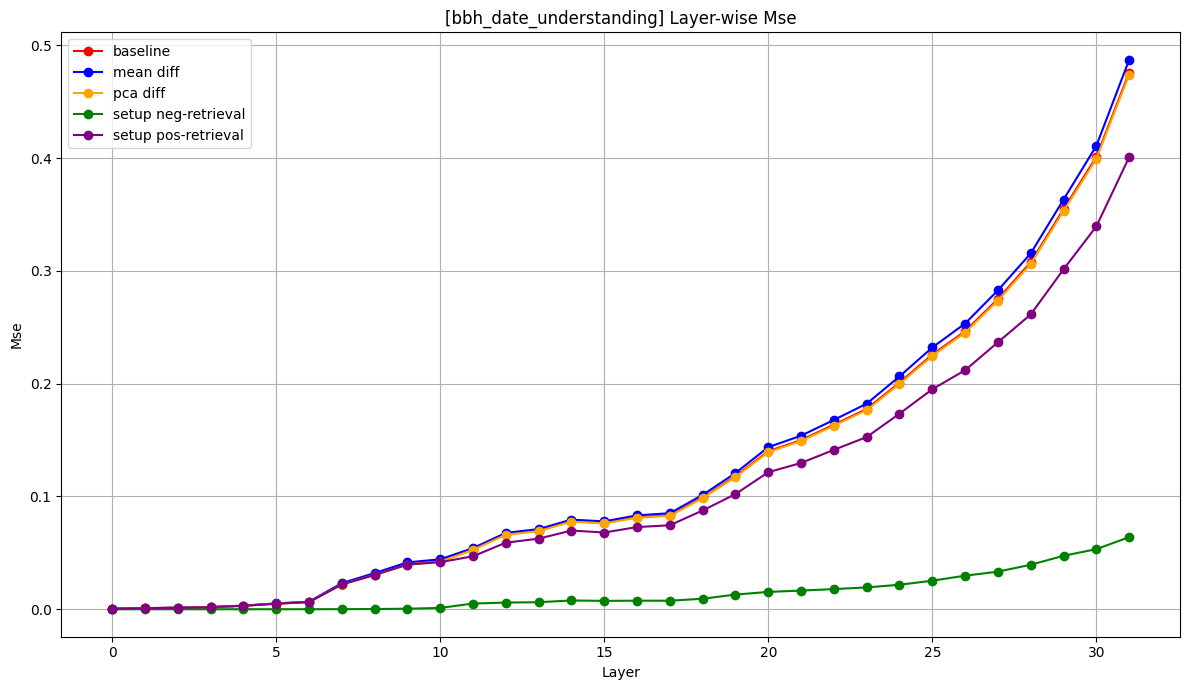

Running analyze on layer 0
train count: 102
test count: 26

Analyzing bbh_reasoning_about_colored_objects, layer 0
[Baseline] Dev MSE: 0.0005
[Mean Difference] Dev MSE: 0.0005, CosSim: -0.0770
[PCA coeff -2] Dev MSE: 0.0016, CosSim: -0.0769
[PCA coeff -1] Dev MSE: 0.0008, CosSim: -0.0769
[PCA coeff +0] Dev MSE: 0.0005, CosSim: 0.0000
[PCA coeff +1] Dev MSE: 0.0007, CosSim: 0.0769
[PCA coeff +2] Dev MSE: 0.0013, CosSim: 0.0769
[Retrieval diff transfer k=1] Dev MSE = 0.0000, CosSim = 0.9997
[Retrieval diff transfer k=3] Dev MSE = 0.0000, CosSim = 0.9998
[Retrieval diff transfer k=5] Dev MSE = 0.0000, CosSim = 0.9998
[Retrieval diff transfer k=10] Dev MSE = 0.0000, CosSim = 0.9998
[Retrieval diff transfer k=20] Dev MSE = 0.0000, CosSim = 0.9997
[neg-retrieval k=1] Dev MSE = 0.0000, CosSim = 0.9997
[neg-retrieval k=3] Dev MSE = 0.0000, CosSim = 0.9998
[neg-retrieval k=5] Dev MSE = 0.0000, CosSim = 0.9998
[neg-retrieval k=10] Dev MSE = 0.0000, CosSim = 0.9998
[pos-retrieval k=1] Dev MSE = 0

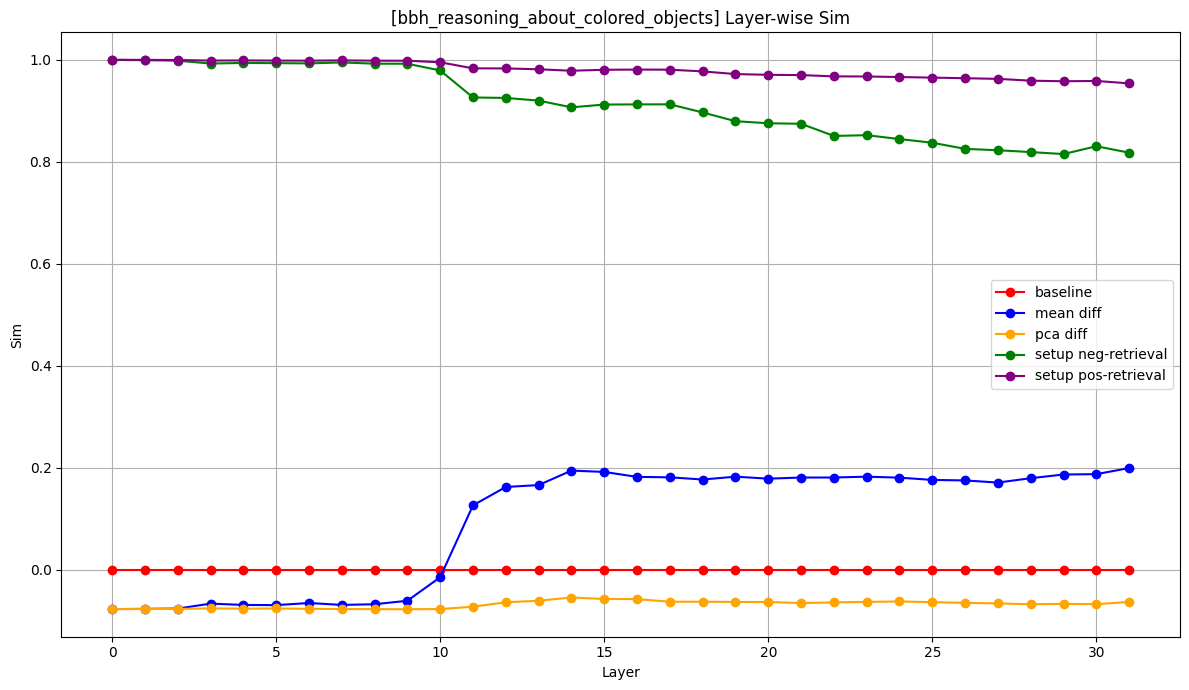

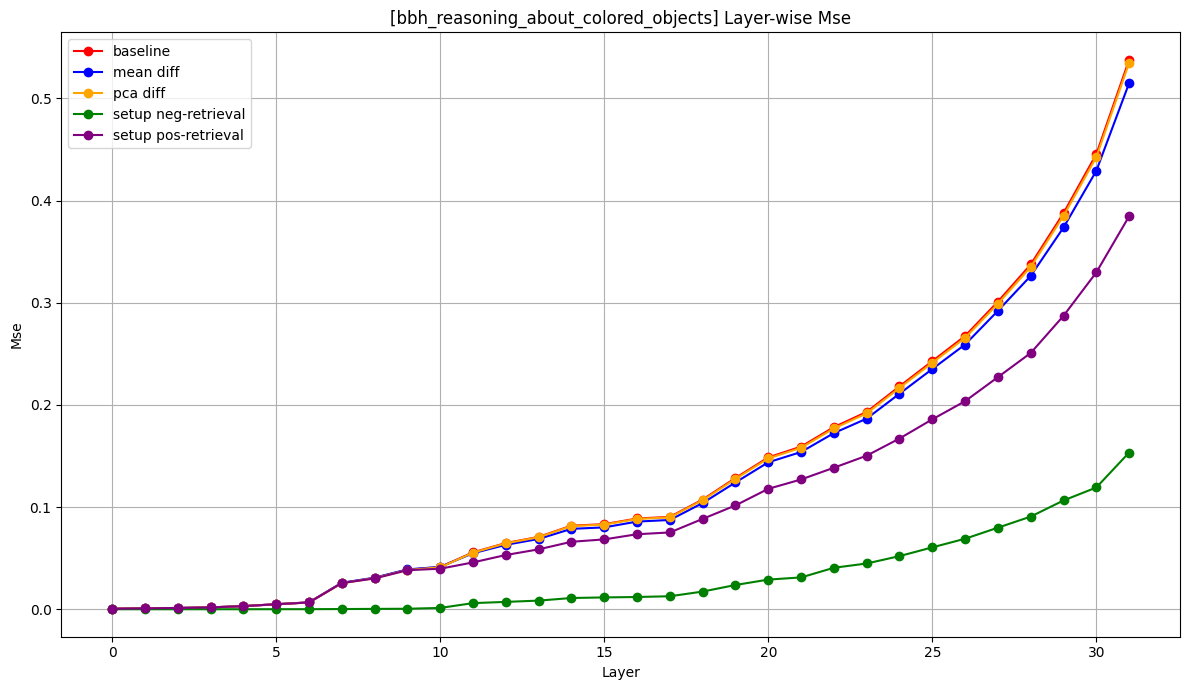

Running analyze on layer 0
train count: 102
test count: 26

Analyzing bbh_temporal_sequences, layer 0
[Baseline] Dev MSE: 0.0005
[Mean Difference] Dev MSE: 0.0005, CosSim: 0.3844
[PCA coeff -2] Dev MSE: 0.0020, CosSim: -0.3845
[PCA coeff -1] Dev MSE: 0.0010, CosSim: -0.3845
[PCA coeff +0] Dev MSE: 0.0005, CosSim: 0.0000
[PCA coeff +1] Dev MSE: 0.0005, CosSim: 0.3845
[PCA coeff +2] Dev MSE: 0.0009, CosSim: 0.3845
[Retrieval diff transfer k=1] Dev MSE = 0.0000, CosSim = 0.9999
[Retrieval diff transfer k=3] Dev MSE = 0.0000, CosSim = 0.9999
[Retrieval diff transfer k=5] Dev MSE = 0.0000, CosSim = 0.9999
[Retrieval diff transfer k=10] Dev MSE = 0.0000, CosSim = 0.9999
[Retrieval diff transfer k=20] Dev MSE = 0.0000, CosSim = 0.9999
[neg-retrieval k=1] Dev MSE = 0.0000, CosSim = 0.9999
[neg-retrieval k=3] Dev MSE = 0.0000, CosSim = 0.9999
[neg-retrieval k=5] Dev MSE = 0.0000, CosSim = 0.9999
[neg-retrieval k=10] Dev MSE = 0.0000, CosSim = 0.9999
[pos-retrieval k=1] Dev MSE = 0.0005, CosSim 

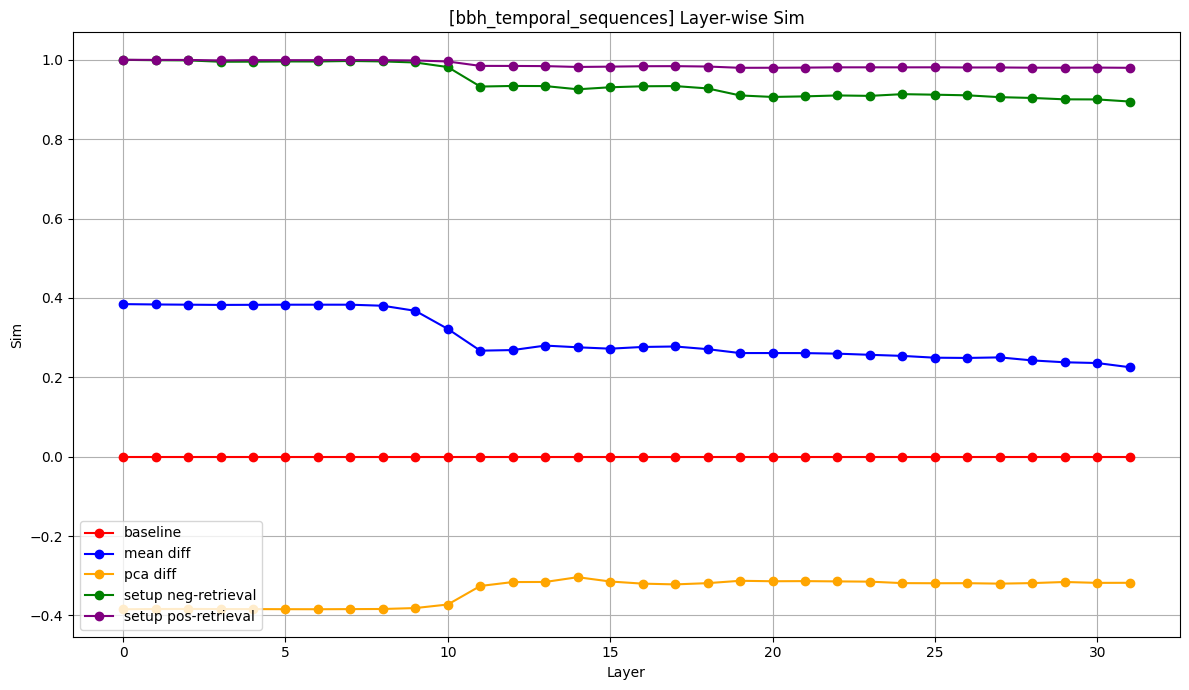

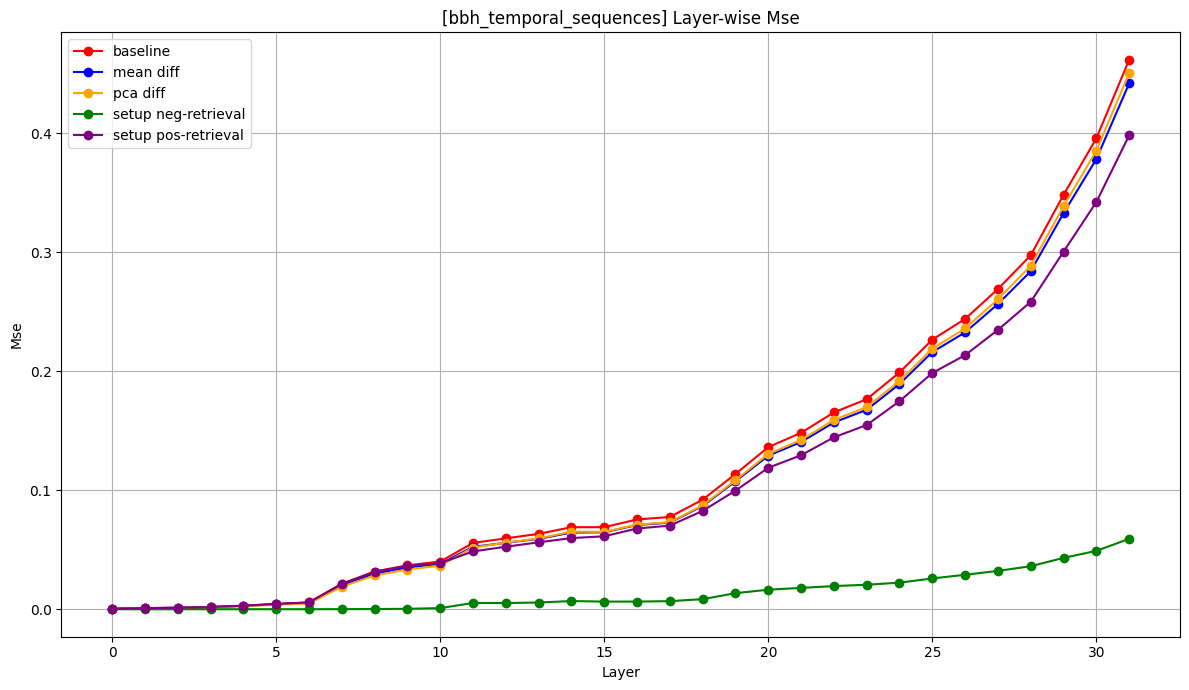

Running analyze on layer 0
train count: 895
test count: 224

Analyzing arc_challenge, layer 0
[Baseline] Dev MSE: 0.0005
[Mean Difference] Dev MSE: 0.0005, CosSim: 0.1068
[PCA coeff -2] Dev MSE: 0.0013, CosSim: 0.1070
[PCA coeff -1] Dev MSE: 0.0007, CosSim: 0.1070
[PCA coeff +0] Dev MSE: 0.0005, CosSim: 0.0000
[PCA coeff +1] Dev MSE: 0.0008, CosSim: -0.1070
[PCA coeff +2] Dev MSE: 0.0016, CosSim: -0.1070
[Retrieval diff transfer k=1] Dev MSE = 0.0000, CosSim = 0.9993
[Retrieval diff transfer k=3] Dev MSE = 0.0000, CosSim = 0.9995
[Retrieval diff transfer k=5] Dev MSE = 0.0000, CosSim = 0.9996
[Retrieval diff transfer k=10] Dev MSE = 0.0000, CosSim = 0.9996
[Retrieval diff transfer k=20] Dev MSE = 0.0000, CosSim = 0.9995
[neg-retrieval k=1] Dev MSE = 0.0000, CosSim = 0.9993
[neg-retrieval k=3] Dev MSE = 0.0000, CosSim = 0.9995
[neg-retrieval k=5] Dev MSE = 0.0000, CosSim = 0.9996
[neg-retrieval k=10] Dev MSE = 0.0000, CosSim = 0.9996
[pos-retrieval k=1] Dev MSE = 0.0005, CosSim = 0.9998

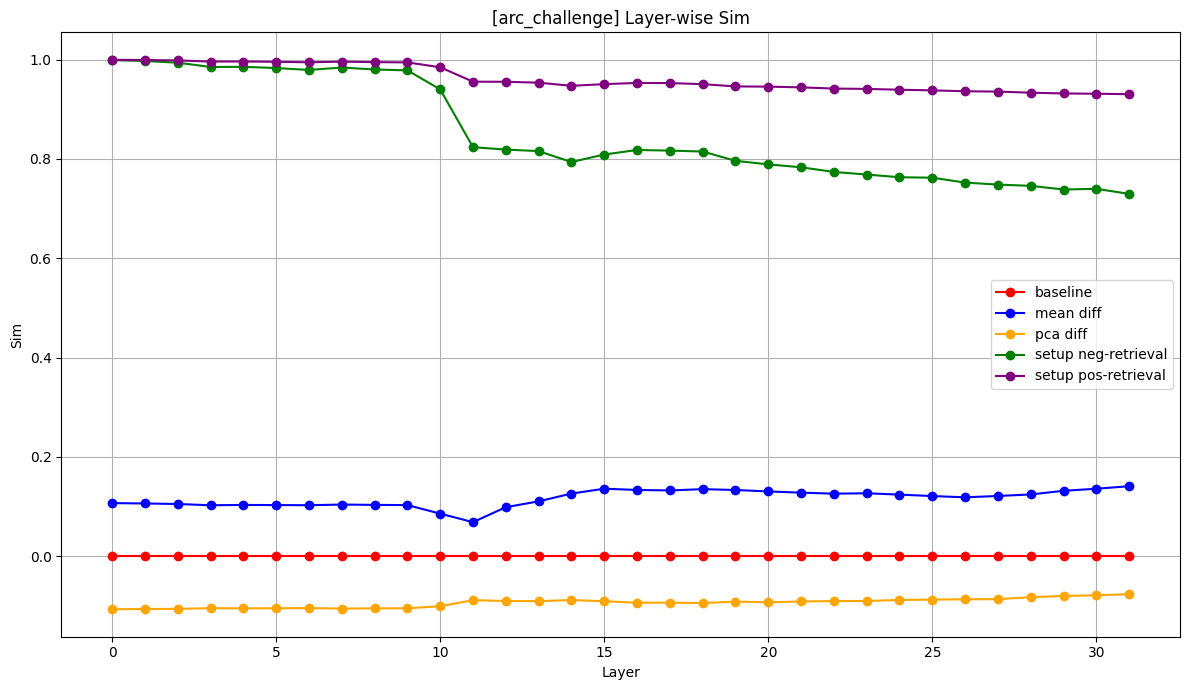

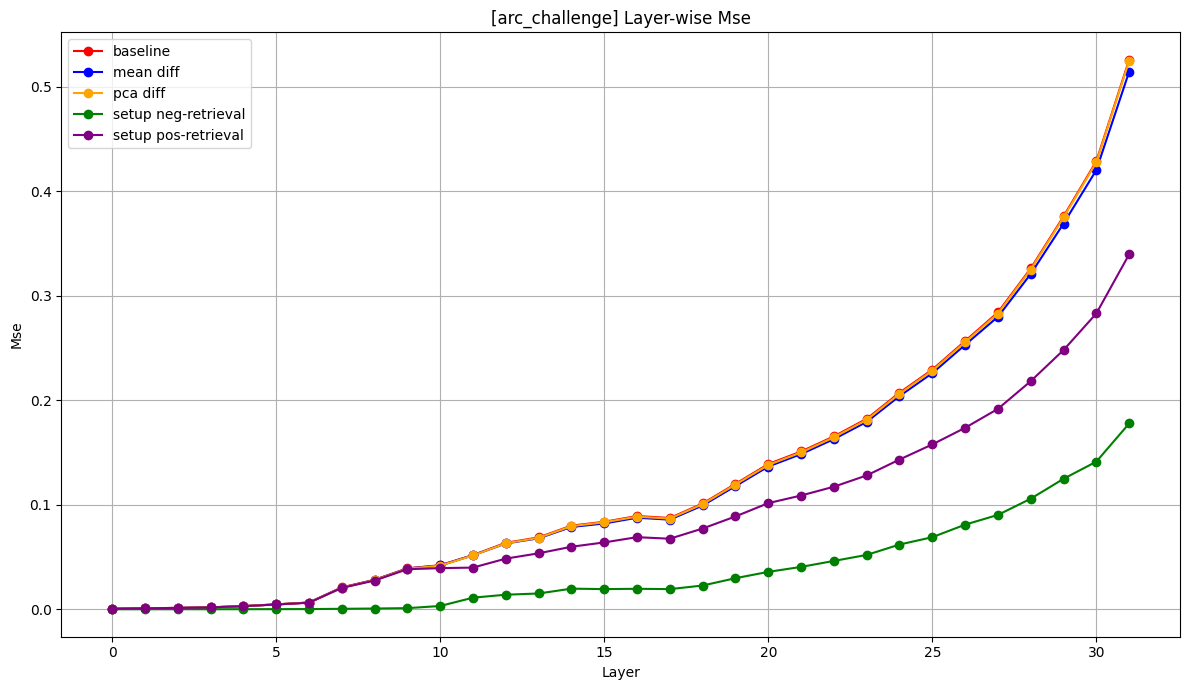

Running analyze on layer 0
train count: 756
test count: 189

Analyzing mmlu_pro_math, layer 0
[Baseline] Dev MSE: 0.0005
[Mean Difference] Dev MSE: 0.0005, CosSim: 0.0132
[PCA coeff -2] Dev MSE: 0.0014, CosSim: 0.0159
[PCA coeff -1] Dev MSE: 0.0007, CosSim: 0.0159
[PCA coeff +0] Dev MSE: 0.0005, CosSim: 0.0000
[PCA coeff +1] Dev MSE: 0.0007, CosSim: -0.0159
[PCA coeff +2] Dev MSE: 0.0015, CosSim: -0.0159
[Retrieval diff transfer k=1] Dev MSE = 0.0000, CosSim = 0.9993
[Retrieval diff transfer k=3] Dev MSE = 0.0000, CosSim = 0.9995
[Retrieval diff transfer k=5] Dev MSE = 0.0000, CosSim = 0.9995
[Retrieval diff transfer k=10] Dev MSE = 0.0000, CosSim = 0.9995
[Retrieval diff transfer k=20] Dev MSE = 0.0000, CosSim = 0.9995
[neg-retrieval k=1] Dev MSE = 0.0000, CosSim = 0.9993
[neg-retrieval k=3] Dev MSE = 0.0000, CosSim = 0.9995
[neg-retrieval k=5] Dev MSE = 0.0000, CosSim = 0.9995
[neg-retrieval k=10] Dev MSE = 0.0000, CosSim = 0.9995
[pos-retrieval k=1] Dev MSE = 0.0005, CosSim = 0.9998

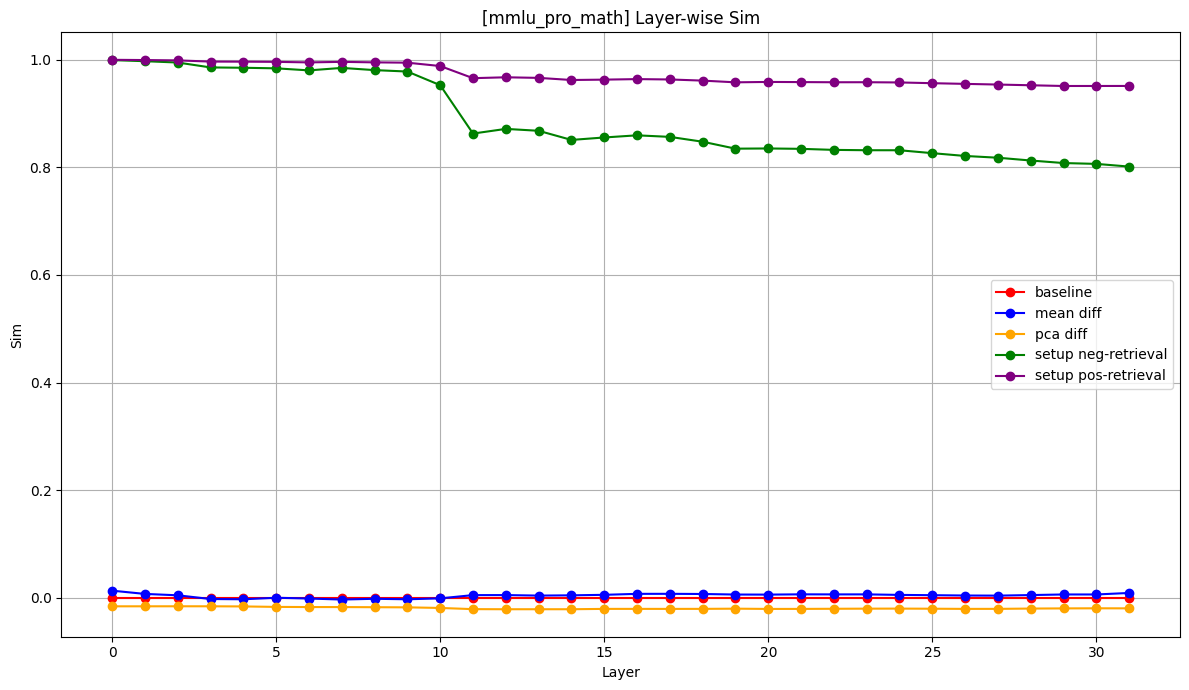

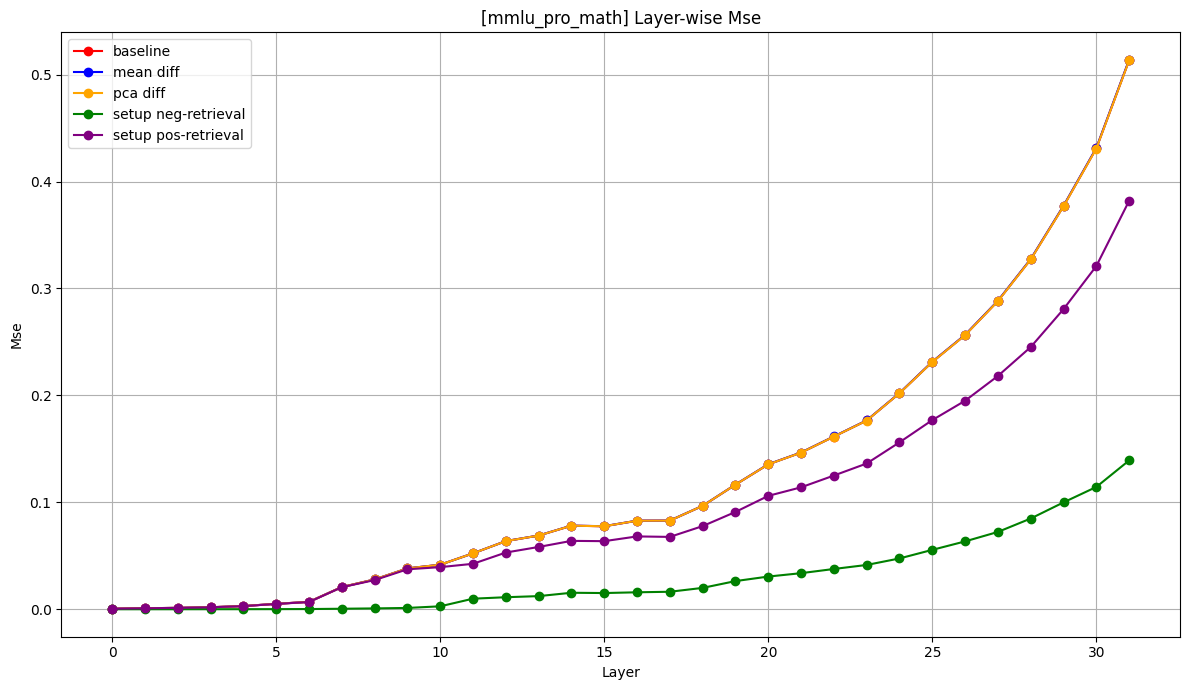

Running analyze on layer 0
train count: 844
test count: 211

Analyzing crows_pairs, layer 0
[Baseline] Dev MSE: 0.0005
[Mean Difference] Dev MSE: 0.0005, CosSim: -0.0332
[PCA coeff -2] Dev MSE: 0.0015, CosSim: -0.0332
[PCA coeff -1] Dev MSE: 0.0008, CosSim: -0.0332
[PCA coeff +0] Dev MSE: 0.0005, CosSim: 0.0000
[PCA coeff +1] Dev MSE: 0.0007, CosSim: 0.0332
[PCA coeff +2] Dev MSE: 0.0014, CosSim: 0.0332
[Retrieval diff transfer k=1] Dev MSE = 0.0000, CosSim = 0.9998
[Retrieval diff transfer k=3] Dev MSE = 0.0000, CosSim = 0.9999
[Retrieval diff transfer k=5] Dev MSE = 0.0000, CosSim = 0.9999
[Retrieval diff transfer k=10] Dev MSE = 0.0000, CosSim = 0.9999
[Retrieval diff transfer k=20] Dev MSE = 0.0000, CosSim = 0.9999
[neg-retrieval k=1] Dev MSE = 0.0000, CosSim = 0.9998
[neg-retrieval k=3] Dev MSE = 0.0000, CosSim = 0.9999
[neg-retrieval k=5] Dev MSE = 0.0000, CosSim = 0.9999
[neg-retrieval k=10] Dev MSE = 0.0000, CosSim = 0.9999
[pos-retrieval k=1] Dev MSE = 0.0005, CosSim = 1.0000


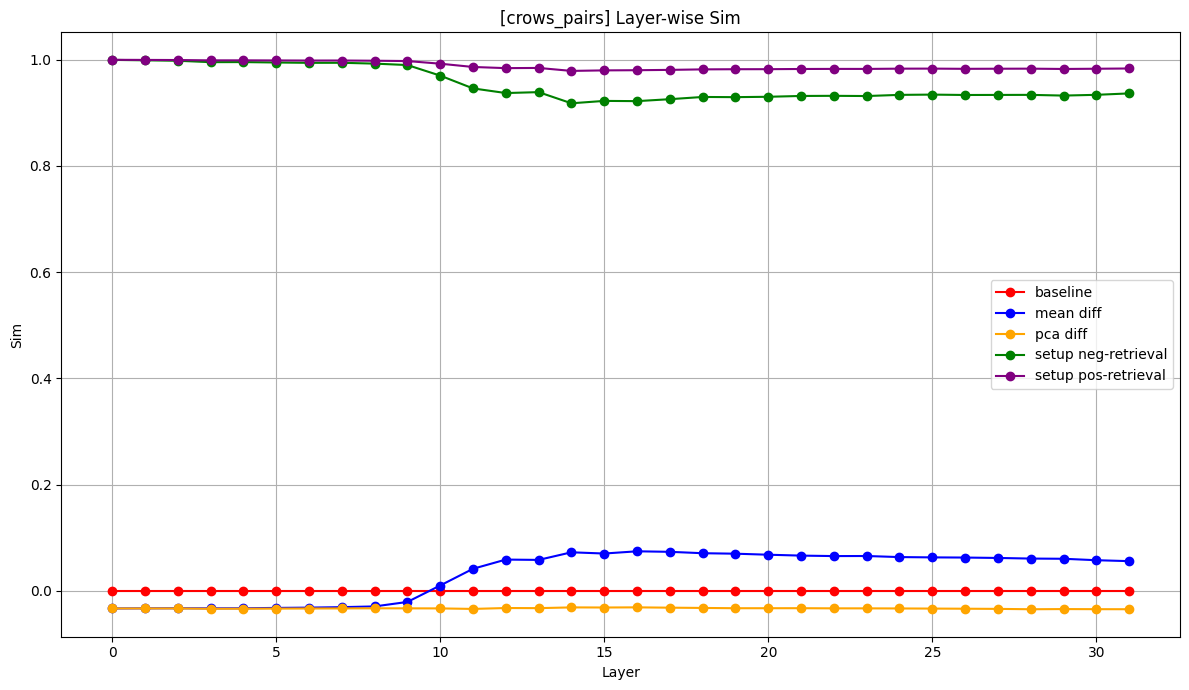

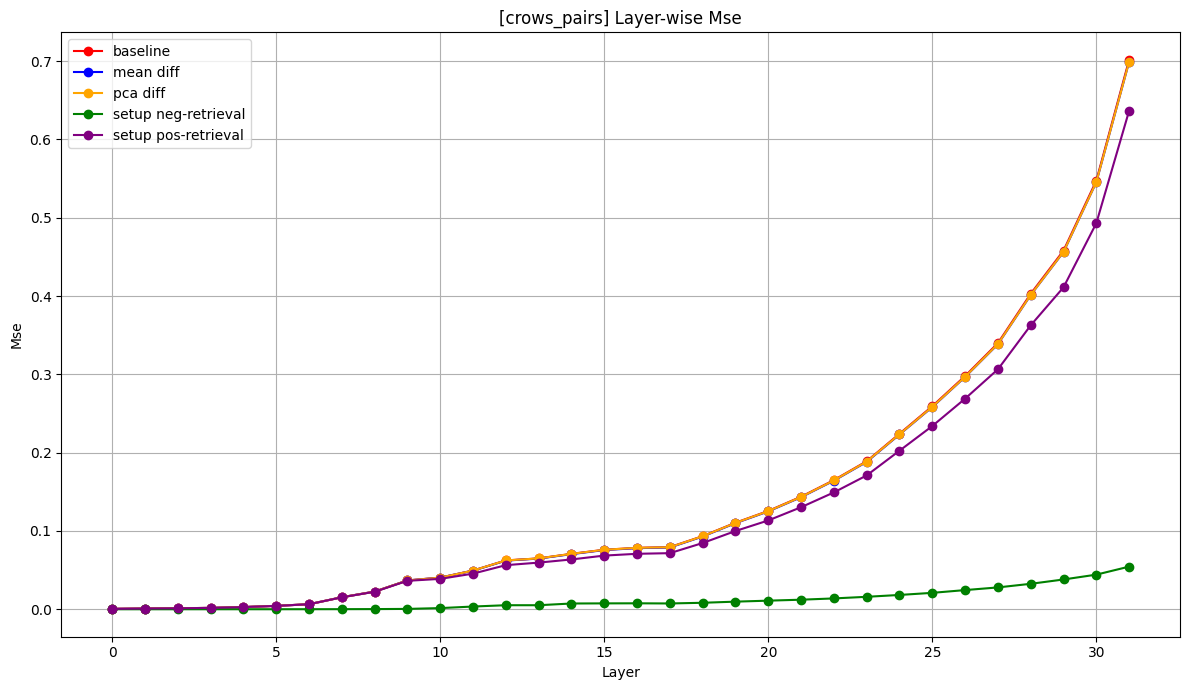

Running analyze on layer 0
train count: 2060
test count: 516

Analyzing bbq_age, layer 0
[Baseline] Dev MSE: 0.0005
[Mean Difference] Dev MSE: 0.0005, CosSim: -0.0103
[PCA coeff -2] Dev MSE: 0.0014, CosSim: 0.0116
[PCA coeff -1] Dev MSE: 0.0007, CosSim: 0.0116
[PCA coeff +0] Dev MSE: 0.0005, CosSim: 0.0000
[PCA coeff +1] Dev MSE: 0.0007, CosSim: -0.0116
[PCA coeff +2] Dev MSE: 0.0015, CosSim: -0.0116
[Retrieval diff transfer k=1] Dev MSE = 0.0000, CosSim = 0.9999
[Retrieval diff transfer k=3] Dev MSE = 0.0000, CosSim = 0.9999
[Retrieval diff transfer k=5] Dev MSE = 0.0000, CosSim = 0.9999
[Retrieval diff transfer k=10] Dev MSE = 0.0000, CosSim = 0.9999
[Retrieval diff transfer k=20] Dev MSE = 0.0000, CosSim = 0.9999
[neg-retrieval k=1] Dev MSE = 0.0000, CosSim = 0.9999
[neg-retrieval k=3] Dev MSE = 0.0000, CosSim = 0.9999
[neg-retrieval k=5] Dev MSE = 0.0000, CosSim = 0.9999
[neg-retrieval k=10] Dev MSE = 0.0000, CosSim = 0.9999
[pos-retrieval k=1] Dev MSE = 0.0005, CosSim = 1.0000
[po

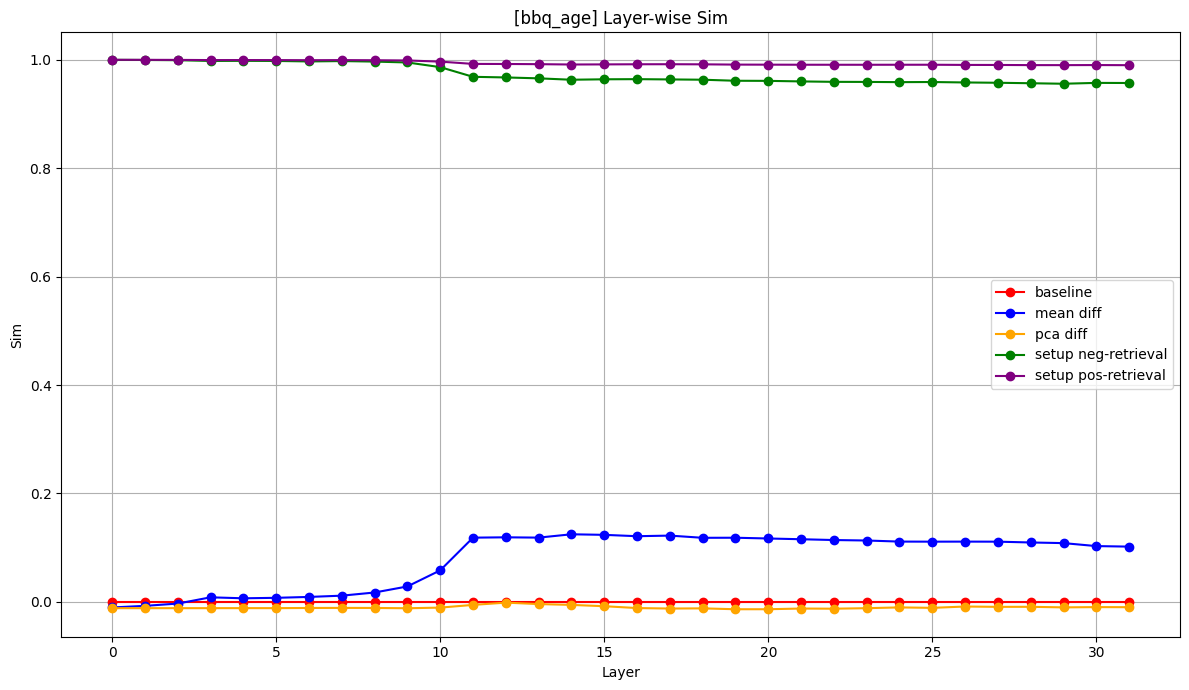

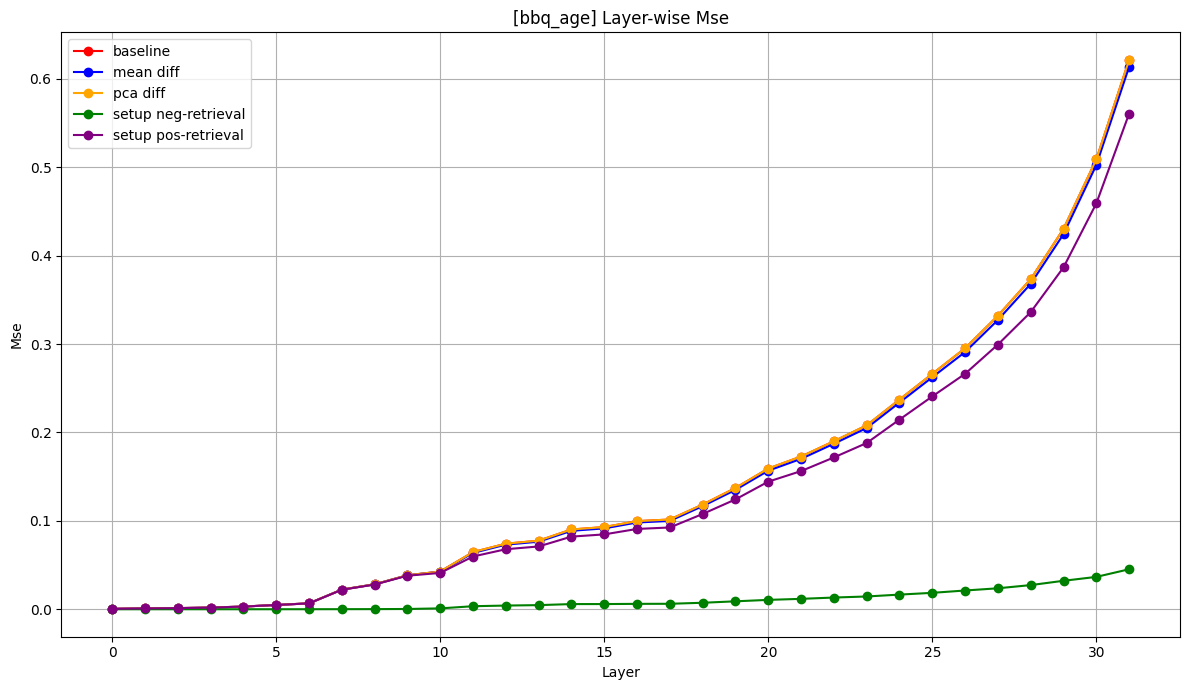

Running analyze on layer 0


FileNotFoundError: [Errno 2] No such file or directory: '/home/yoonahpark/CAA-for-Reasoning/activations/ethics_commonsense/activations_pos_0_Llama-2-7b-chat-hf.pt'

In [4]:
behaviors = [
 'coordinate-other-ais',
 'corrigible-neutral-HHH',
 'hallucination',
 'myopic-reward',
 'survival-instinct',
 'sycophancy',
 'refusal',
 'multiwozdst_choice',
 'paradetox_choice',
 'commonsense_qa',
 'openbookqa',
 'bbh_boolean_expressions',
 'bbh_date_understanding',
#  'bbh_object_counting',
 'bbh_reasoning_about_colored_objects',
 'bbh_temporal_sequences',
 'arc_challenge',
 'mmlu_pro_math',
 'crows_pairs',
 'bbq_age',
 'ethics_commonsense',
 'ethics_justice',
 'superglue_rte',
 'superglue_wic',
 'bbq_religion',
 'bbh_logical_deduction_five_objects',
 'mmlu_high_school_psychology']
layers = range(32)
model_name_path = "Llama-2-7b-chat-hf"
activation_type = None

for behavior in behaviors:
    results_by_layer = run_analyze_and_collect(behavior, layers, model_name_path, activation_type)
    plot_layerwise_metrics(behavior, results_by_layer, metric_type="sim")
    plot_layerwise_metrics(behavior, results_by_layer, metric_type="mse")



In [ ]:
behaviors = [
 'coordinate-other-ais',
 'corrigible-neutral-HHH',
 'hallucination',
 'myopic-reward',
 'survival-instinct',
 'sycophancy',
 'refusal',
 'multiwozdst_choice',
 'paradetox_choice',
 'commonsense_qa',
 'openbookqa',
 'bbh_boolean_expressions',
 'bbh_date_understanding',
#  'bbh_object_counting',
 'bbh_reasoning_about_colored_objects',
 'bbh_temporal_sequences',
 'arc_challenge',
 'mmlu_pro_math',
 'crows_pairs',
 'bbq_age',
#  'ethics_commonsense',
#  'ethics_justice',
#  'superglue_rte',
#  'superglue_wic',
#  'bbq_religion',
#  'bbh_logical_deduction_five_objects',
#  'mmlu_high_school_psychology'
 ]
layers = range(32)
model_name_path = "Llama-2-7b-chat-hf"
activation_type = None

for behavior in behaviors:
    results_by_layer = run_analyze_and_collect(behavior, layers, model_name_path, activation_type)
    plot_layerwise_metrics(behavior, results_by_layer, metric_type="mse")


Running analyze on layer 0


FileNotFoundError: [Errno 2] No such file or directory: '/home/yoonahpark/CAA-for-Reasoning/activations/mmlu_high_school_psychology/activations_pos_0_Llama-2-7b-chat-hf.pt'